# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

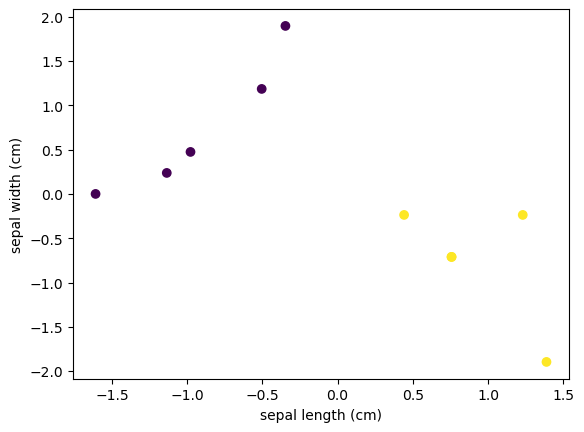

In [5]:
n = 10
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [6]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [7]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b'] + [f'u_{i}' for i in range(1, 11)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.021727800369262695
Optimal objective value: 0.8050052238402077
SCS solver iterations: 125
SCS solve time: 0.0031035620000000002
SCS setup time: 0.0039637349999999995
Optimal w:  [ 1.0562039  -0.70316695]
Optimal b:  [0.36667032]
Dual variables (Lagrange multipliers): [0.26073366 0.         0.27347295 0.80499977 0.         0.
 0.         0.         0.         0.27079356]
Constraints: [-0.00000222 -2.1666768  -0.00000128 -0.00000586 -0.3333306  -0.66667396
 -0.33333817 -0.8333433  -0.66667396  0.00000156]


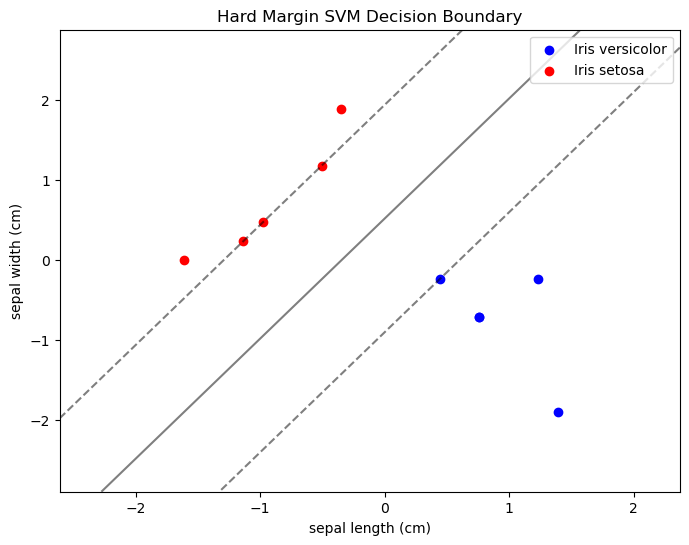

In [8]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [9]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.001).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [10]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 0.8051453
Constraints: [-0.0000387  -2.1673625  -0.00031028  0.00031625 -0.33513632 -0.66662
 -0.33296365 -0.8326751  -0.66662    -0.00112504]
max diff: 0.0018057227 mean diff: 0.0018057227
w diff: [0.00043869 0.00085775] b diff: [0.00033159]


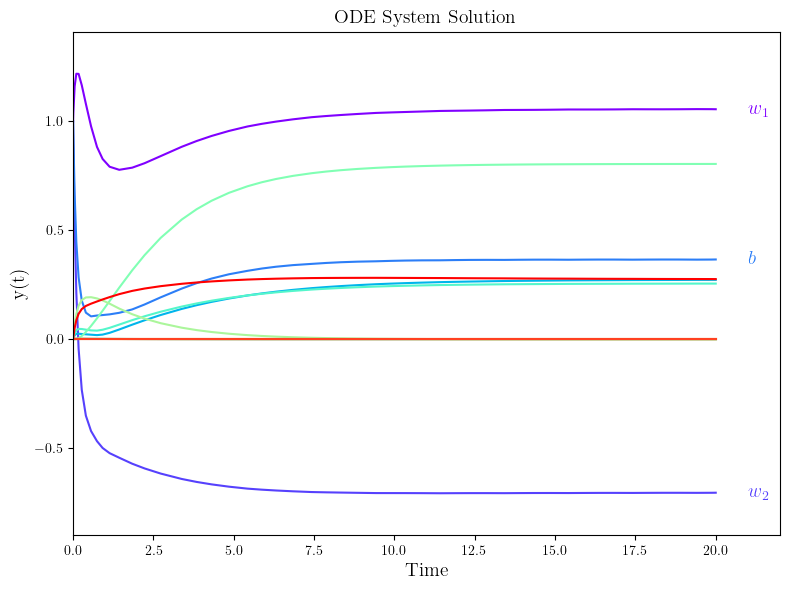

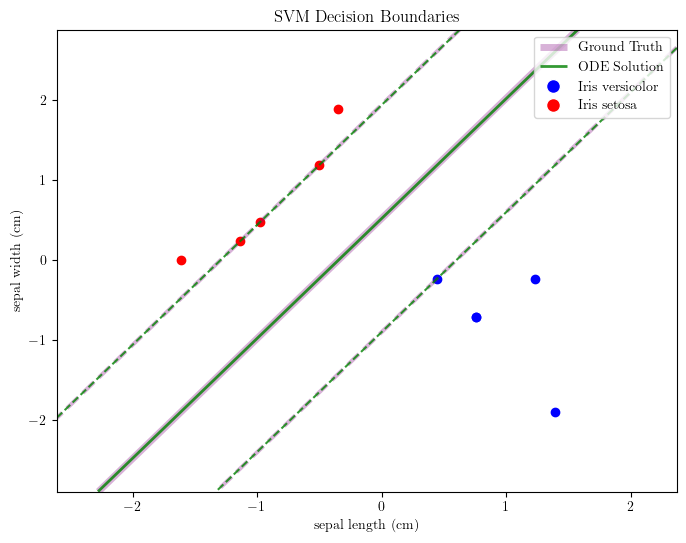

In [11]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 20)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 0.8051453
Constraints: [-0.0000387  -2.1673625  -0.00031028  0.00031625 -0.33513632 -0.66662
 -0.33296365 -0.8326751  -0.66662    -0.00112504]
max diff: 0.0018057227 mean diff: 0.0018057227
w diff: [0.00043869 0.00085775] b diff: [0.00033159]
Time: 0.3348960876464844


In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 0.8057554
Constraints: [-0.00114194 -2.1674902  -0.0011504   0.0002181  -0.33468568 -0.66676784
 -0.33461794 -0.8334931  -0.66676784 -0.00117581]
max diff: 0.0013550818 mean diff: 0.0013550818
w diff: [0.00047367 0.00035506] b diff: [0.0005174]
Time: 0.783090353012085


In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 0.80517226
Constraints: [-0.00026066 -2.1668544  -0.00026254  0.00004982 -0.33364168 -0.66668963
 -0.33362663 -0.8333698  -0.66668963 -0.00026819]
max diff: 0.00031107664 mean diff: 0.00031107664
w diff: [0.00010409 0.00008123] b diff: [0.00012093]
Time: 1.4231669902801514


# 3. The method

In [15]:
T=20.0

In [16]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [17]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*((t / T).detach().reshape((-1, ))**2))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        FIXED_PENALTY = 1.0
        PENALTY_SCALE = 2.0
        epsilon = 1e-3
        
        x = y[:, :nx].cpu().detach().numpy()
        g_values = torch.tensor(g_batch(x)).cuda()
        
        penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
        
        logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()
        
        constraint_loss = torch.sum(logarithmic_penalty, axis=1) # [NBATCH]
        constraint_weight  = torch.exp(-WEIGTHING * ((1 - t / T).detach().reshape((-1,))**2))
        constraint_loss = constraint_weight * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [18]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [19]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          non_inifinty_ratio = len([num for num in L_epsilon_curr if not  np.isinf(num)]) / len(L_epsilon_curr)
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'ratio:', non_inifinty_ratio, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'mse': mse_, 'ratio': non_inifinty_ratio, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [20]:
T=20.0
NBATCH = 512
ITERATIONS = 1000
NEURONS=100
LR=0.01
LAYERS=2
hyperparameter_combinations = []

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9671918 MSE solution: 0.00825379498111032 ratio: 0.073 time: 55.34430813789368
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9231417 MSE solution: 0.005260117055031016 ratio: 0.109 time: 59.16120910644531
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83938164 MSE solution: 0.0003231024065659455 ratio: 0.128 time: 60.90241241455078


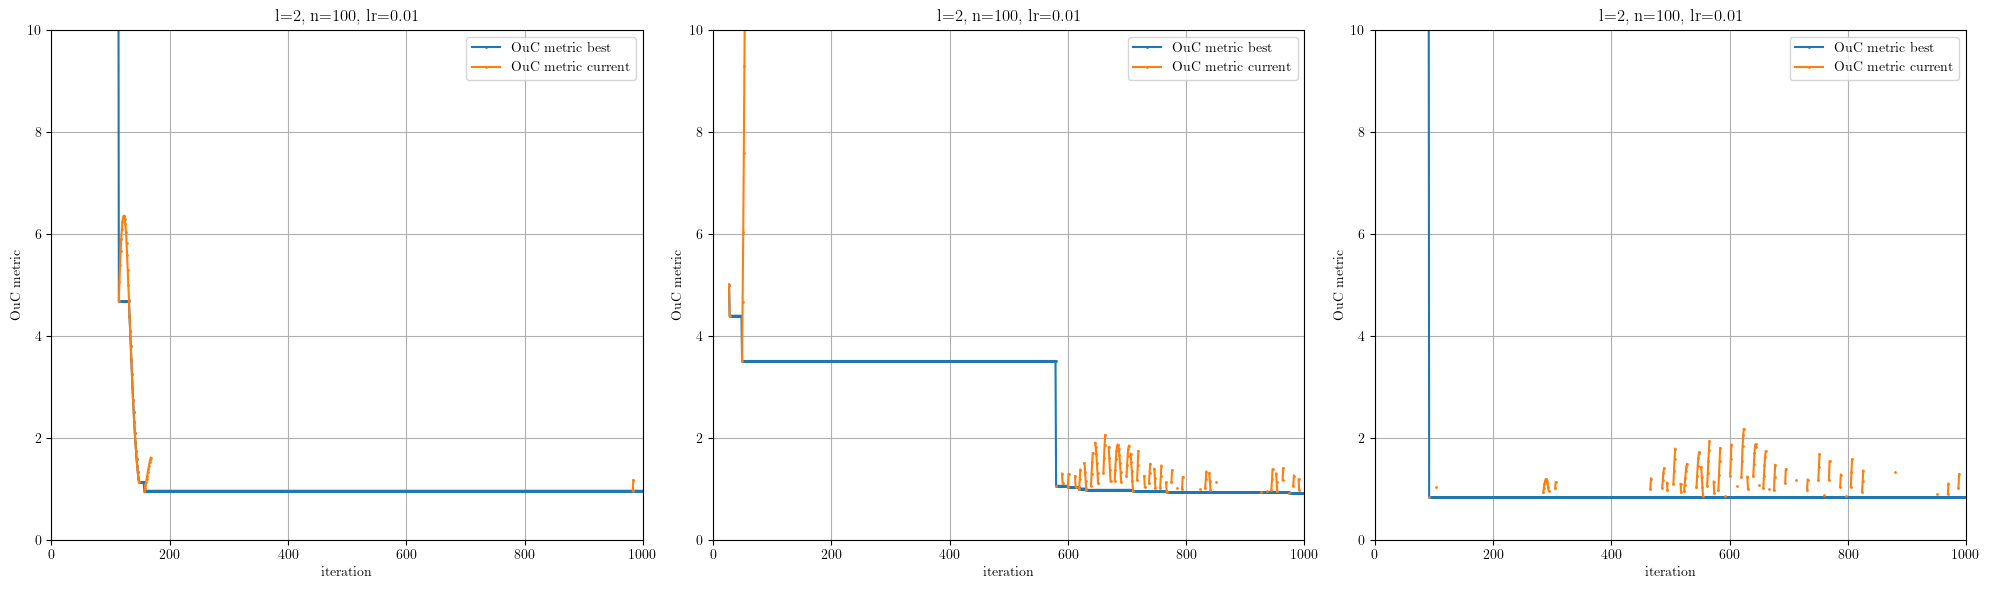

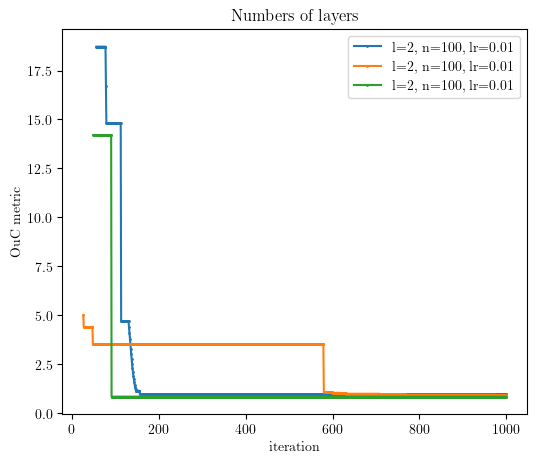

In [21]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85079026 MSE solution: 0.00043499088300489095 ratio: 0.128 time: 59.58961629867554
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.840559 MSE solution: 0.0003088459808997985 ratio: 0.177 time: 54.021029472351074
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 11.526673 MSE solution: 6.589624063149444 ratio: 0.023 time: 58.14925456047058


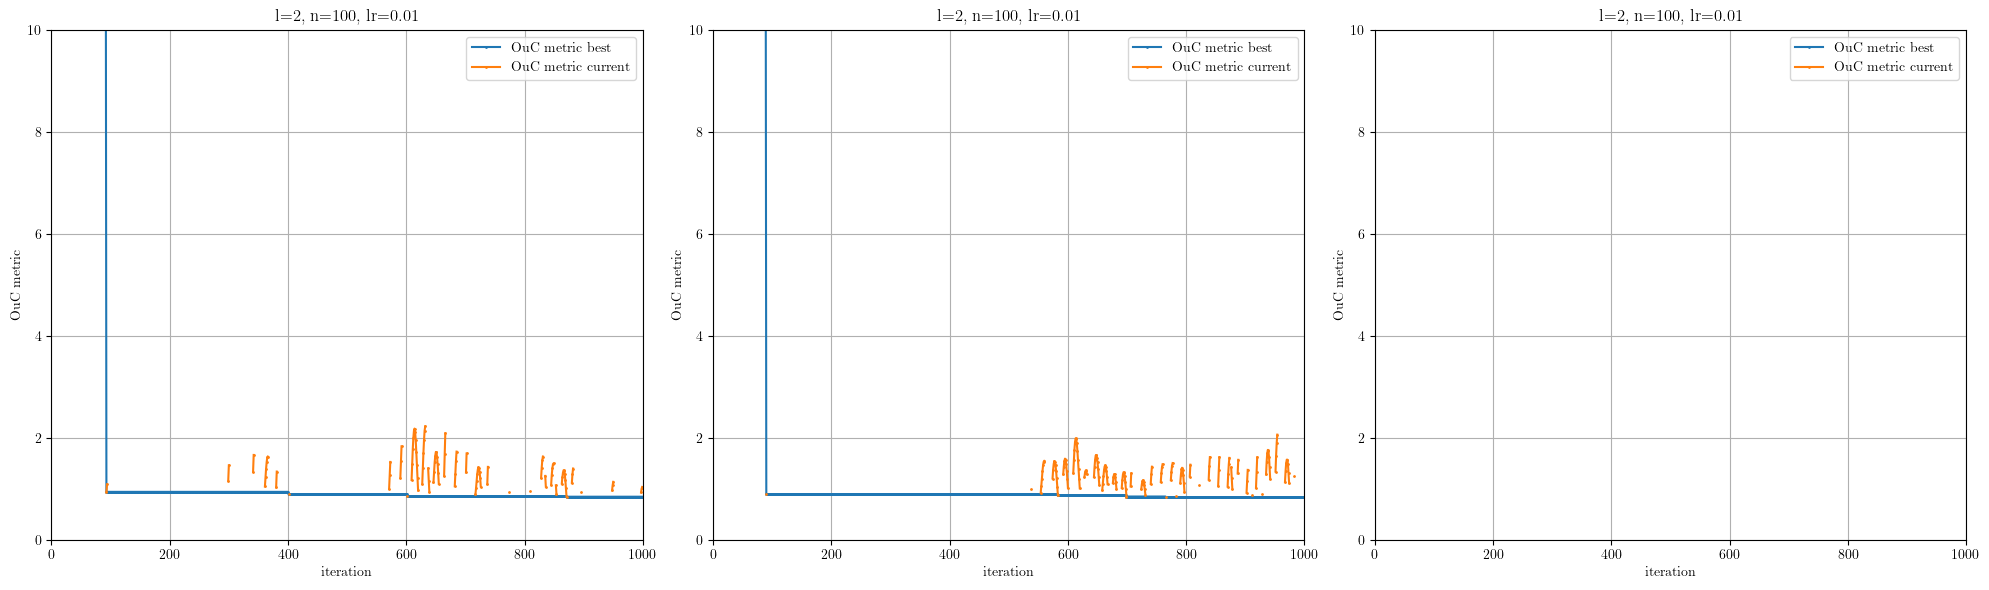

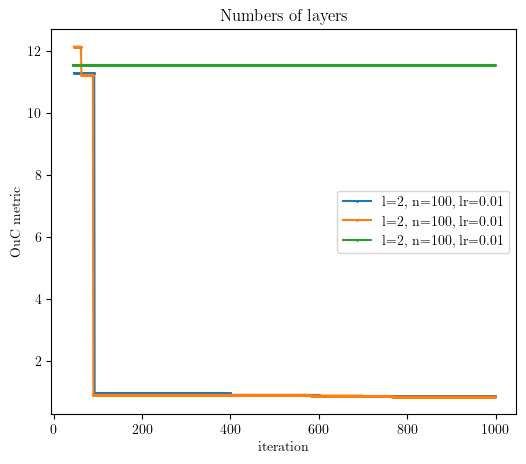

In [22]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9500808 MSE solution: 0.012003384357567043 ratio: 0.046 time: 58.89508533477783
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85781133 MSE solution: 0.0022122665679409795 ratio: 0.184 time: 57.88596773147583
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 12.20209 MSE solution: 6.785256646277176 ratio: 0.024 time: 57.29663705825806


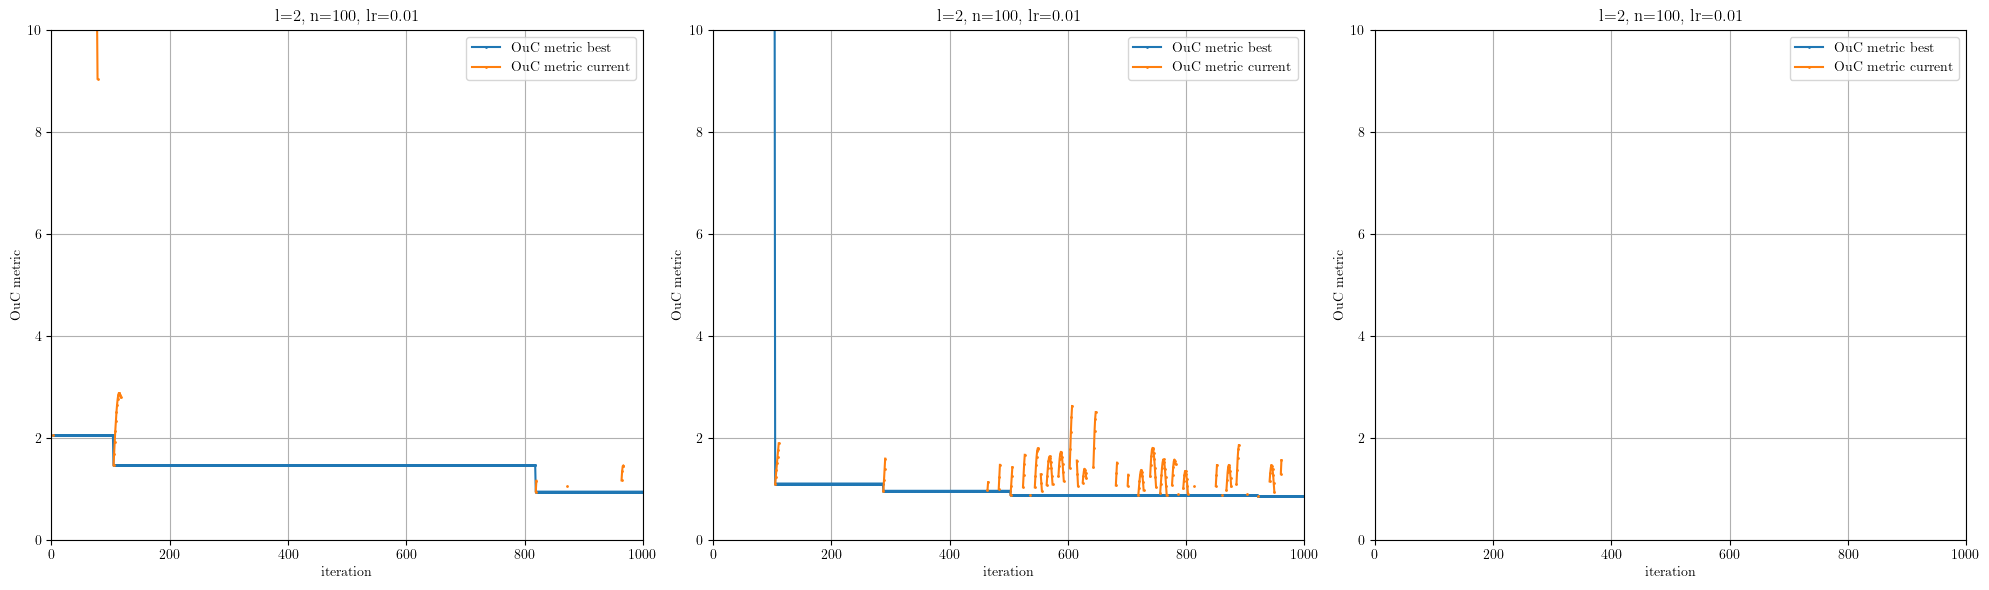

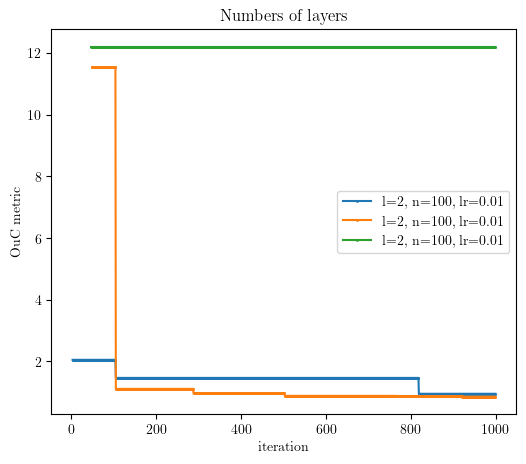

In [23]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8571238 MSE solution: 0.0008699948091568181 ratio: 0.085 time: 58.08569073677063
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87739295 MSE solution: 0.0011105161358135034 ratio: 0.19 time: 59.03546357154846
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.3655095 MSE solution: 0.4272495989957004 ratio: 0.045 time: 60.29752206802368


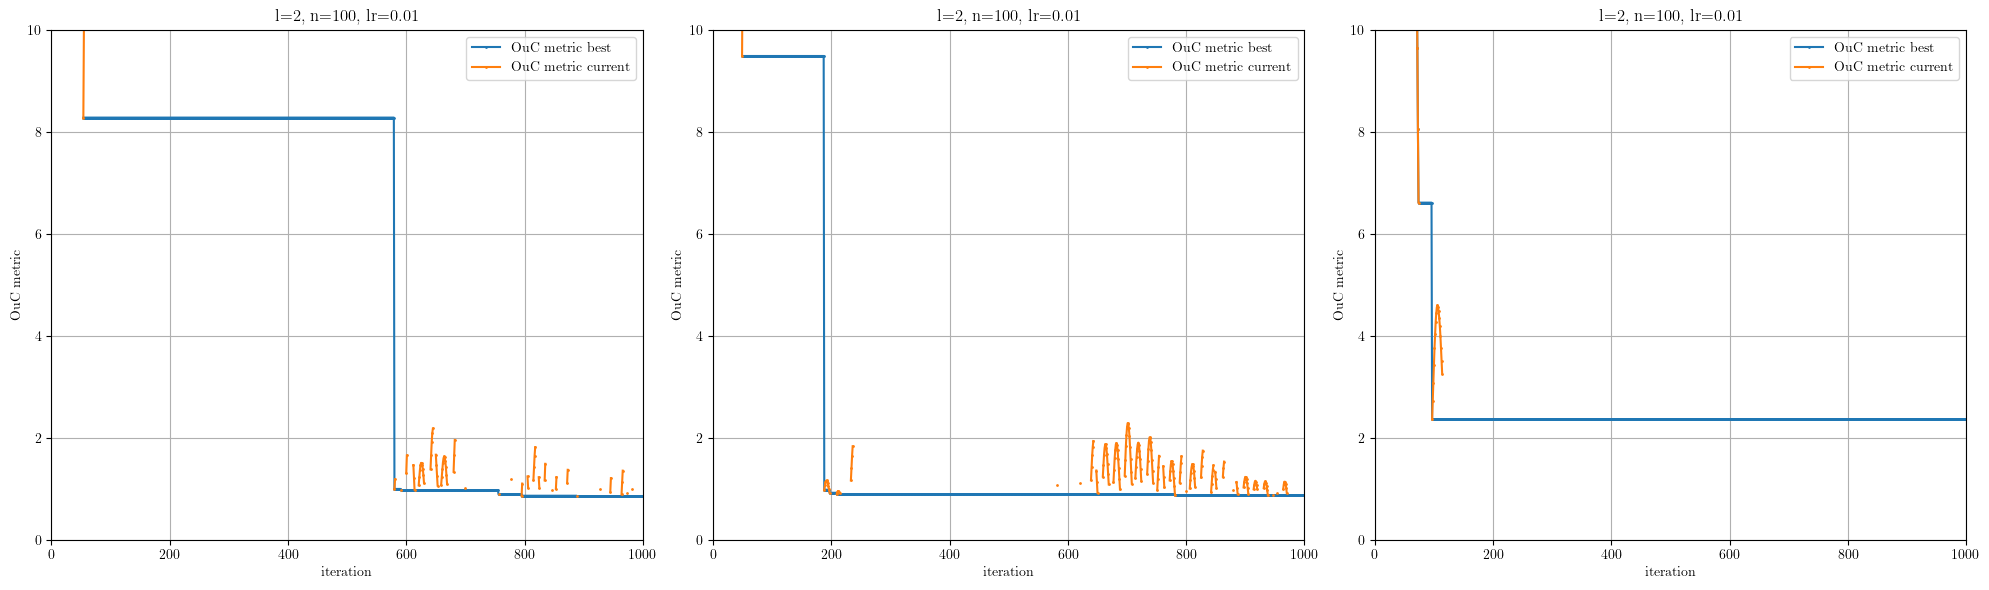

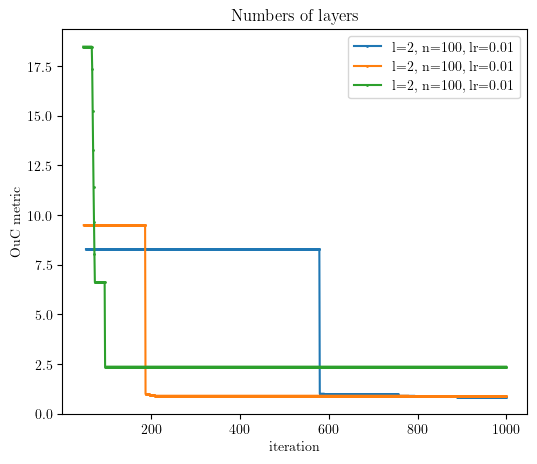

In [24]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85864395 MSE solution: 0.001016089662198943 ratio: 0.111 time: 58.43264675140381
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88493687 MSE solution: 0.008255590721112996 ratio: 0.167 time: 56.64759302139282
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.89703983 MSE solution: 0.006638254019432333 ratio: 0.044 time: 56.3608980178833


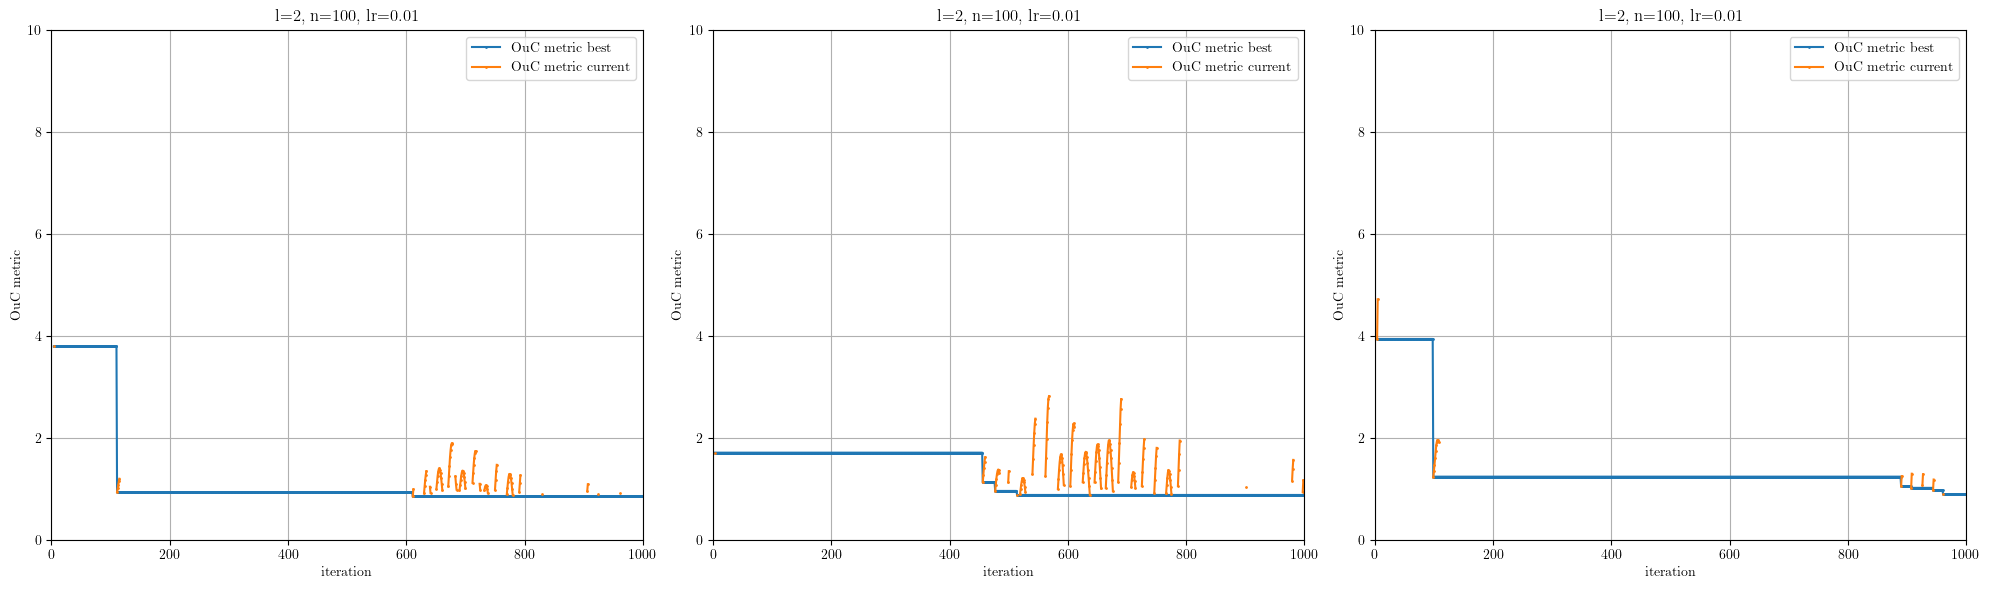

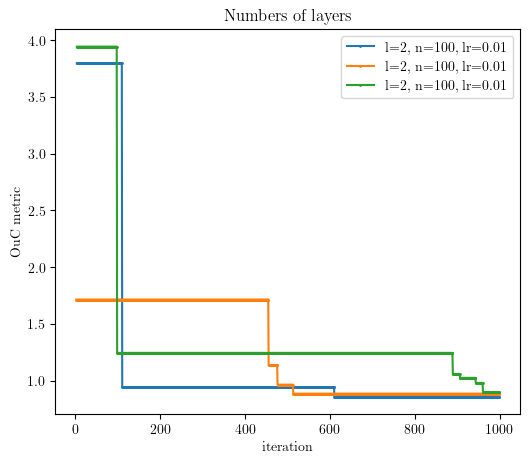

In [25]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88061863 MSE solution: 0.0022473531005889045 ratio: 0.103 time: 57.94926571846008
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9036027 MSE solution: 0.0027487306455911517 ratio: 0.087 time: 56.412574768066406
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8846218 MSE solution: 0.0024069644194079287 ratio: 0.123 time: 58.57952833175659


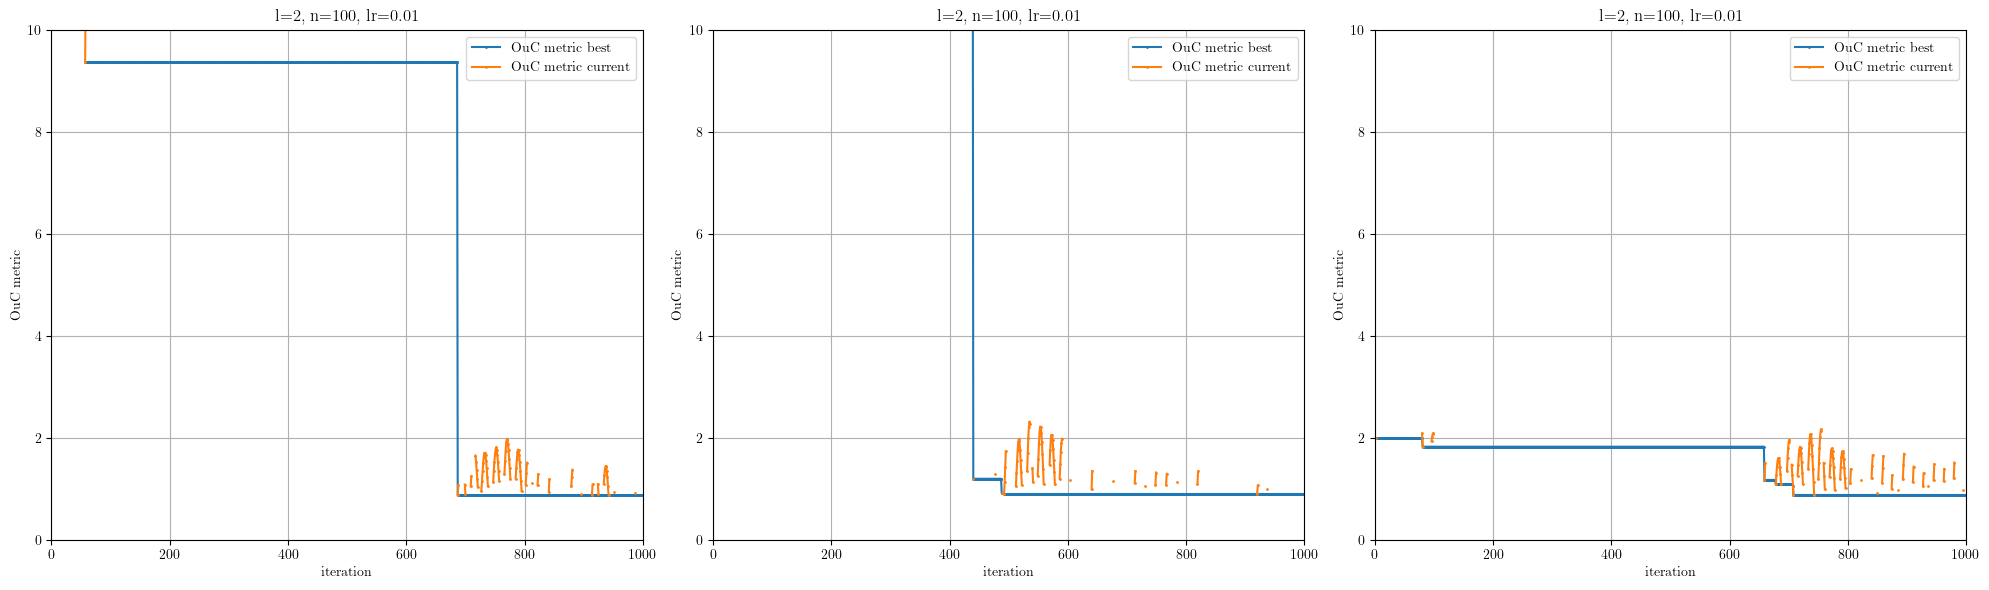

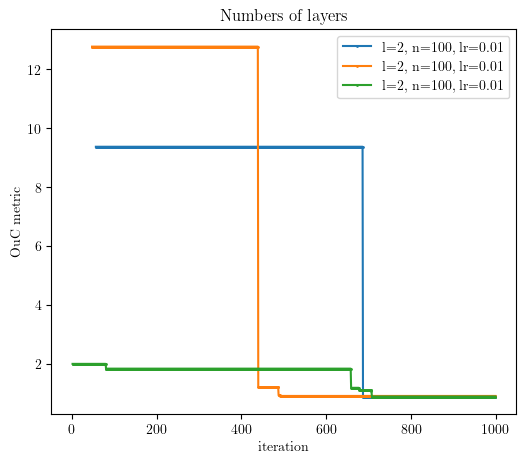

In [26]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84739083 MSE solution: 0.0006608567619944737 ratio: 0.191 time: 58.53085899353027
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8638586 MSE solution: 0.0016338574815449218 ratio: 0.054 time: 55.48006749153137
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.4282411 MSE solution: 0.07462746664076676 ratio: 0.015 time: 55.92619585990906


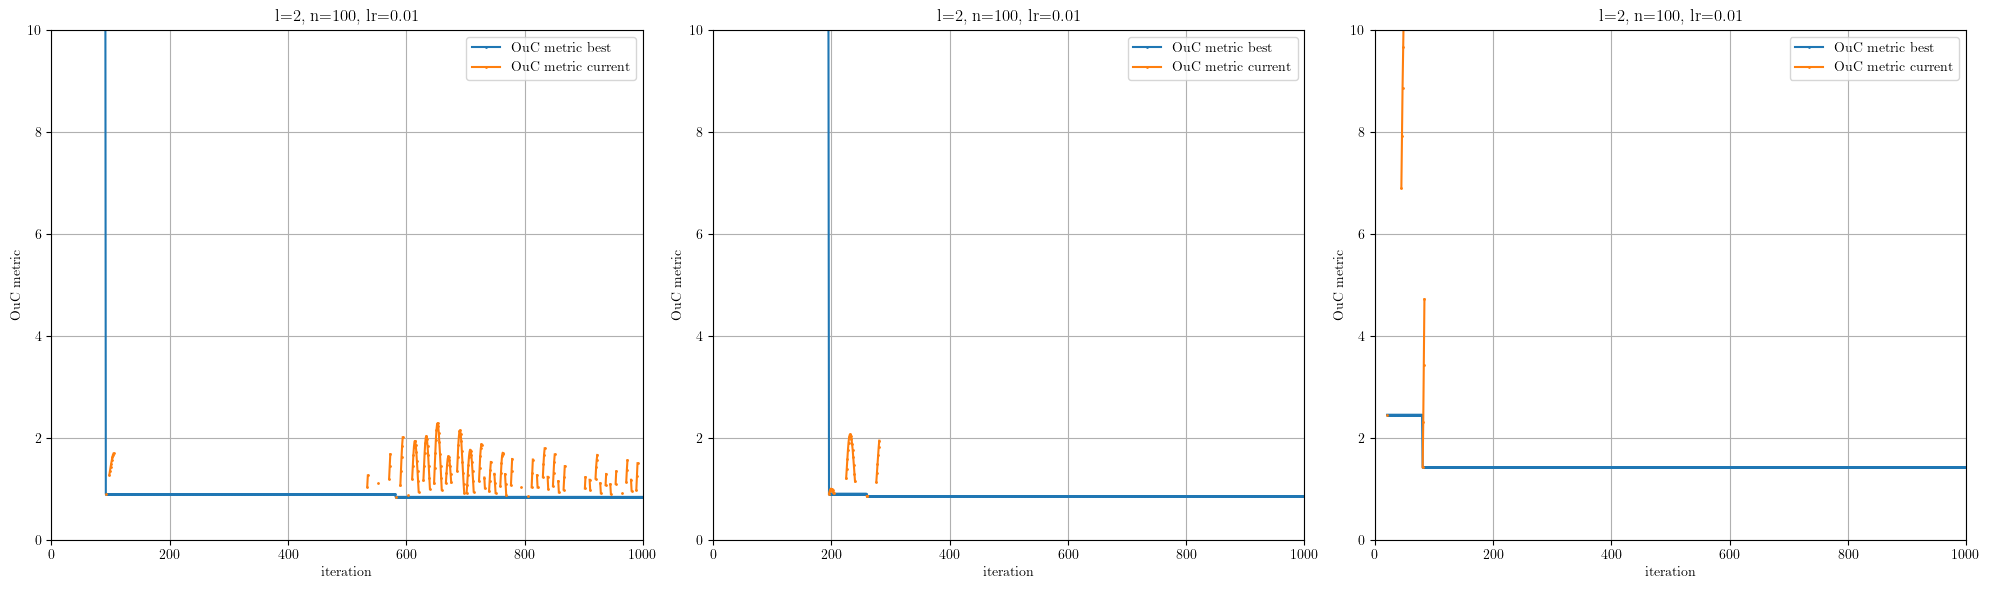

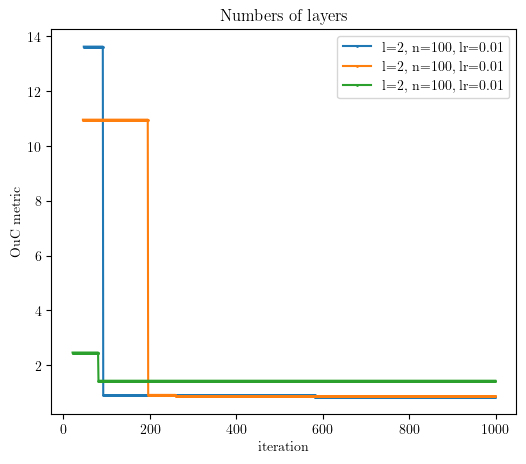

In [27]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9681764 MSE solution: 0.013523337043195277 ratio: 0.052 time: 57.171414375305176
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8831235 MSE solution: 0.00528941073584041 ratio: 0.115 time: 56.054567098617554
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8193405 MSE solution: 0.00040811397213889547 ratio: 0.032 time: 55.40356731414795


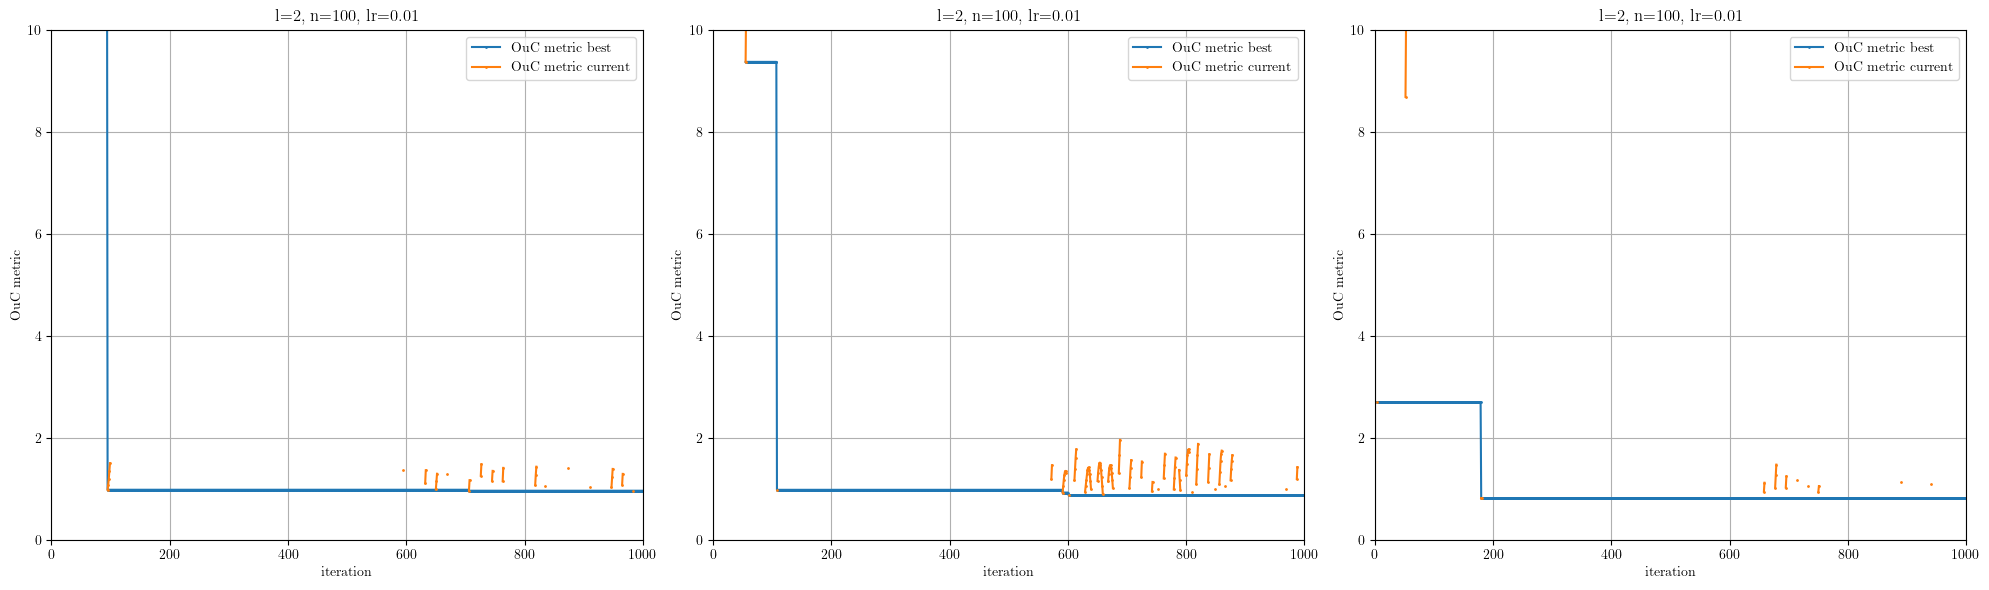

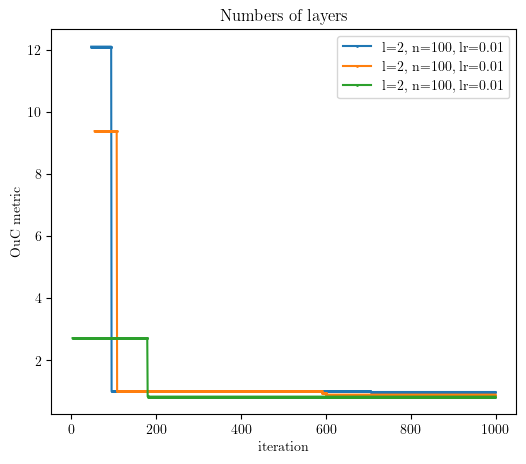

In [28]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8194585 MSE solution: 7.3431745332727e-05 ratio: 0.105 time: 60.37530589103699
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8531118 MSE solution: 0.0005802228324673658 ratio: 0.121 time: 58.854968547821045
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9390336 MSE solution: 0.006676129942973064 ratio: 0.098 time: 59.526406049728394


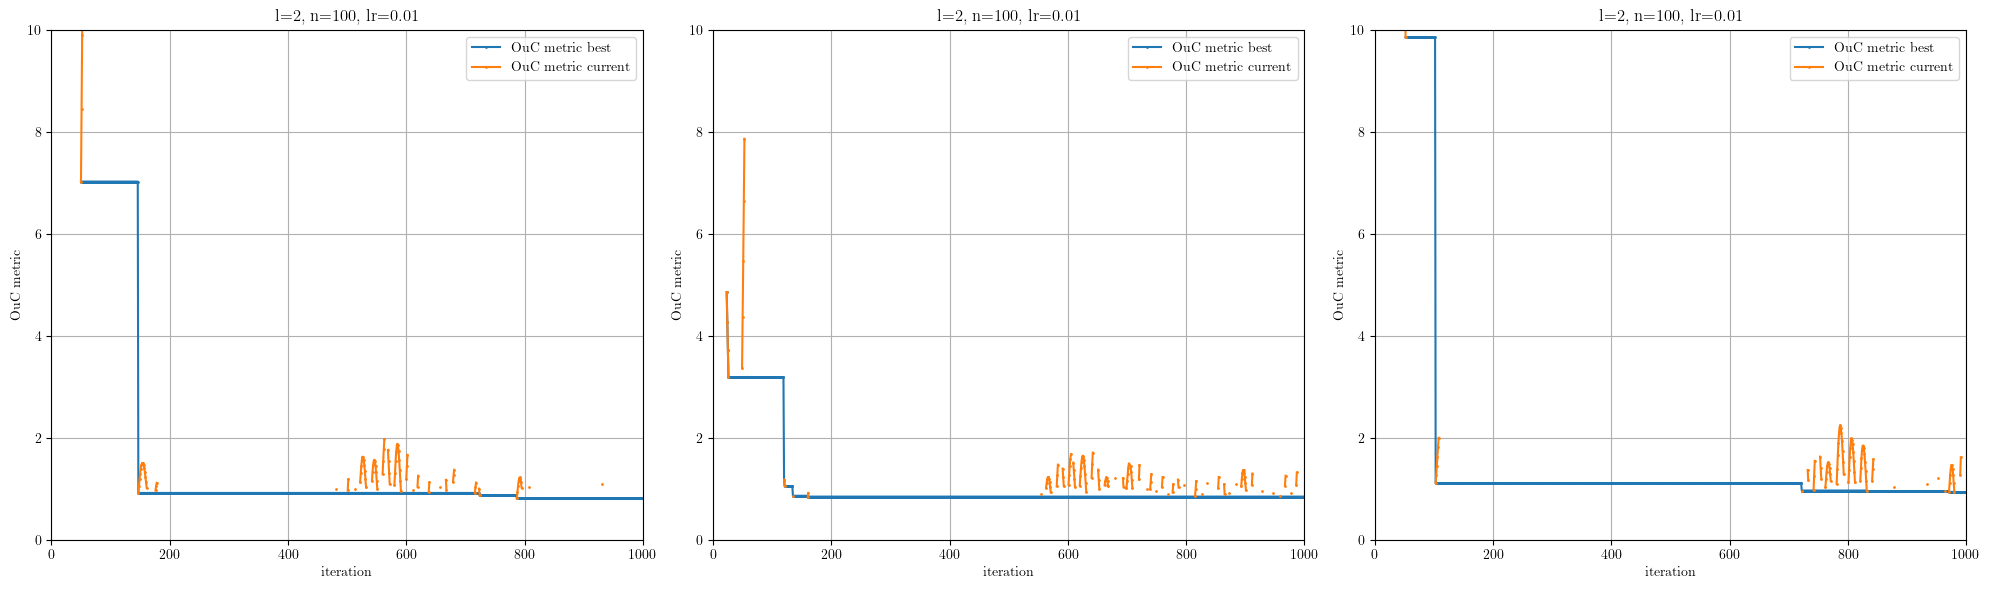

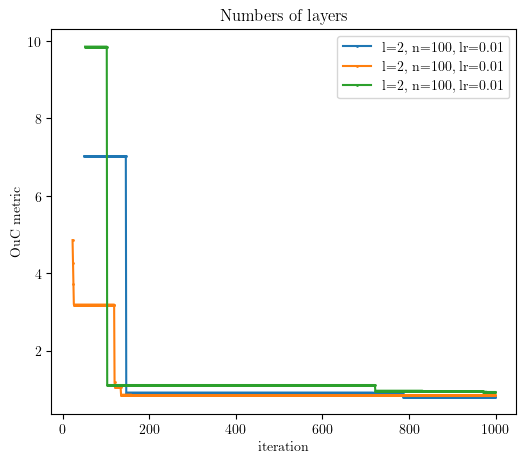

In [29]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.91125214 MSE solution: 0.008093908764964844 ratio: 0.136 time: 58.55497932434082
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82237166 MSE solution: 6.111790343375115e-05 ratio: 0.101 time: 61.10116505622864
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.95133704 MSE solution: 0.012385409837666365 ratio: 0.042 time: 58.07451677322388


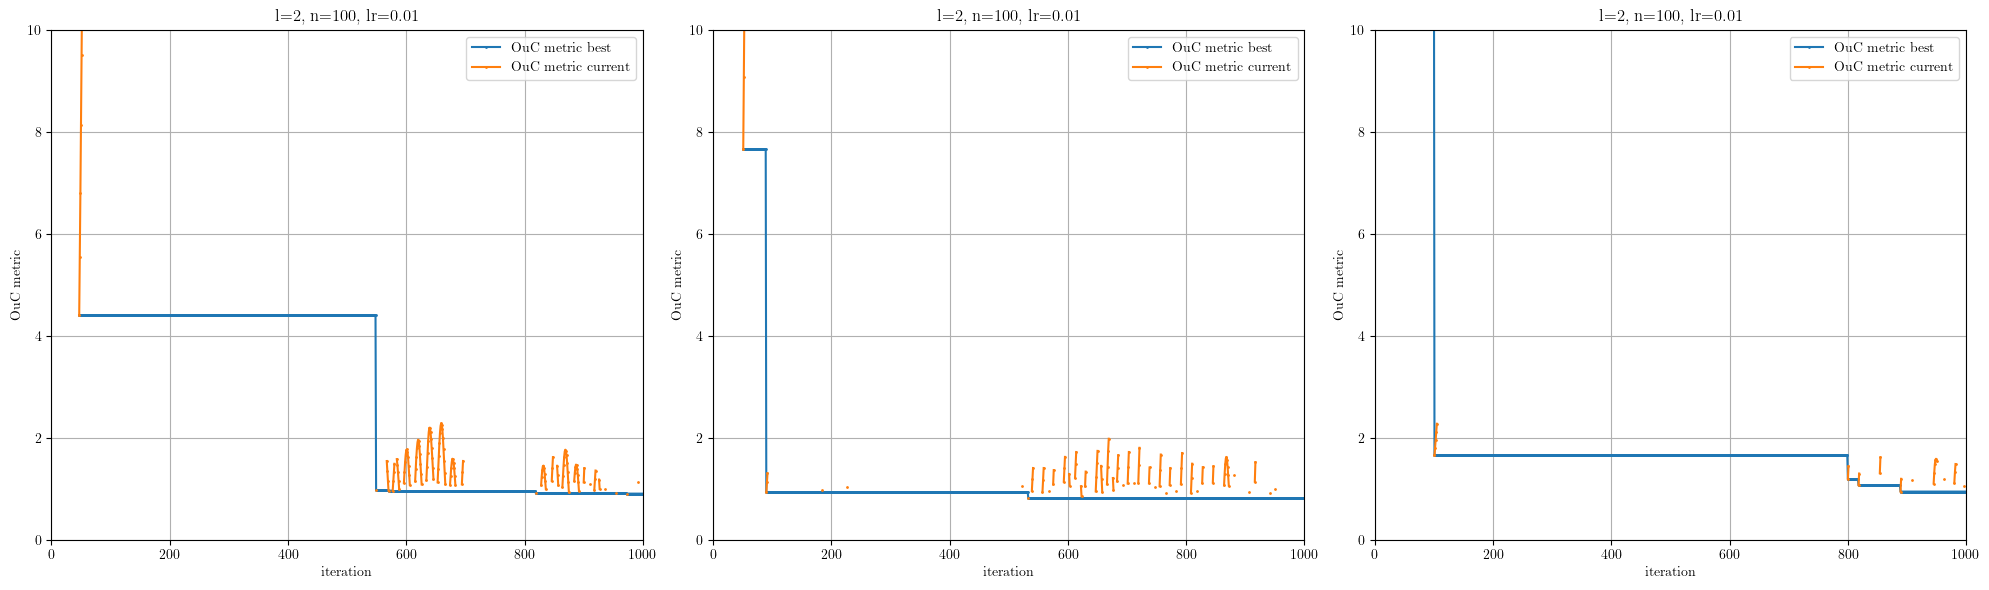

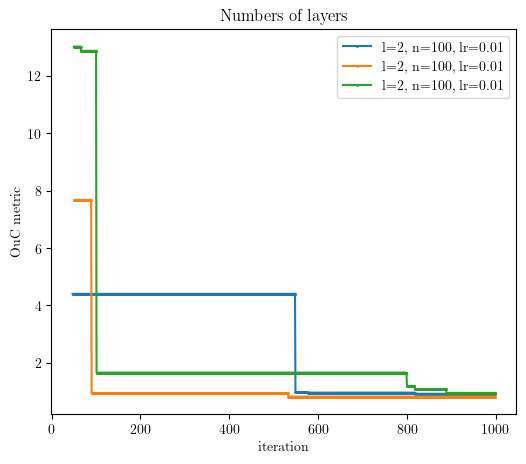

In [30]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8465902 MSE solution: 0.00034966455013248814 ratio: 0.081 time: 58.252668380737305
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8523253 MSE solution: 0.000689404871177505 ratio: 0.154 time: 56.17245650291443
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.7569329 MSE solution: 0.19264038432220887 ratio: 0.047 time: 53.99067521095276


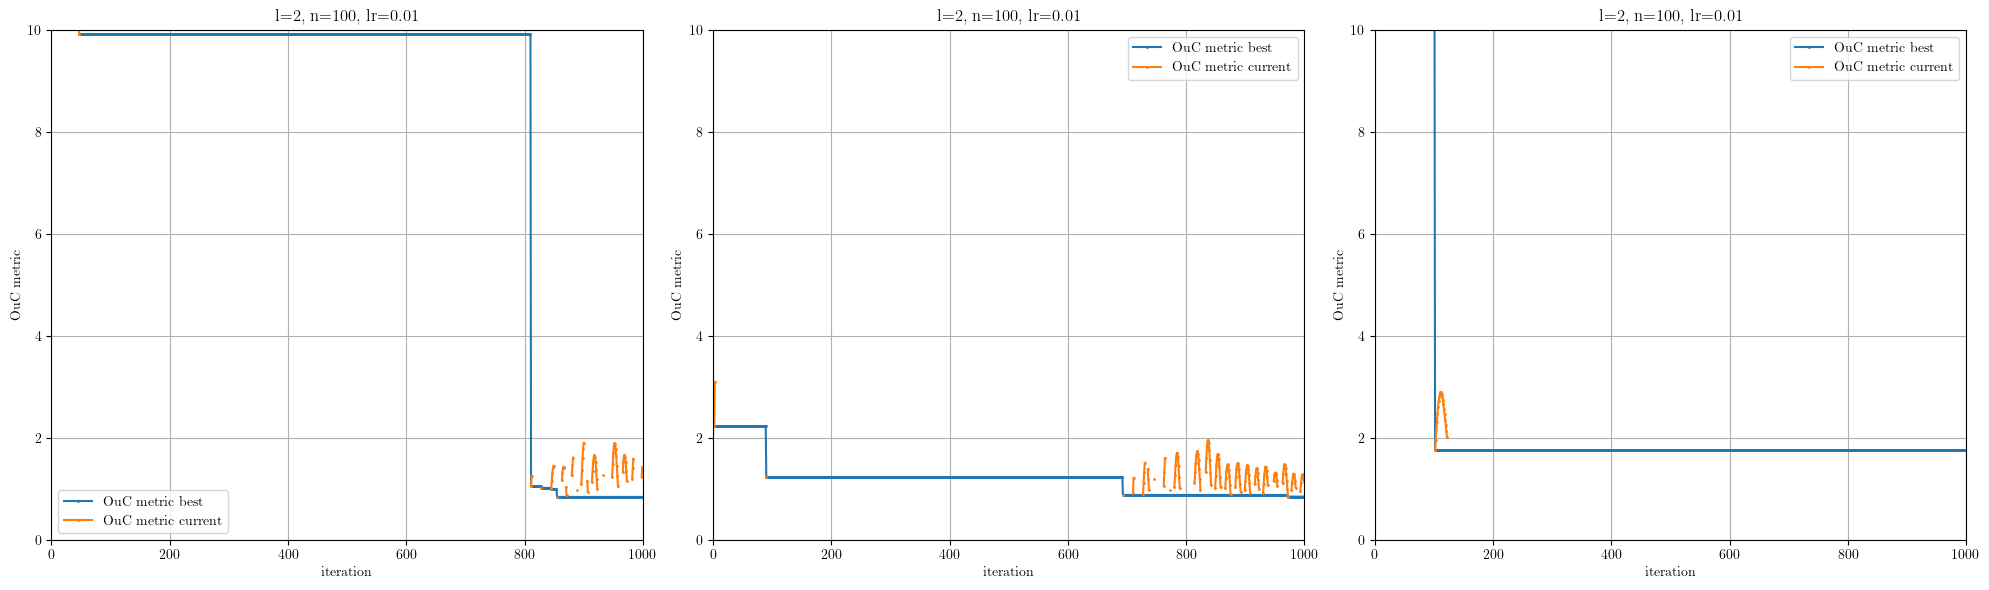

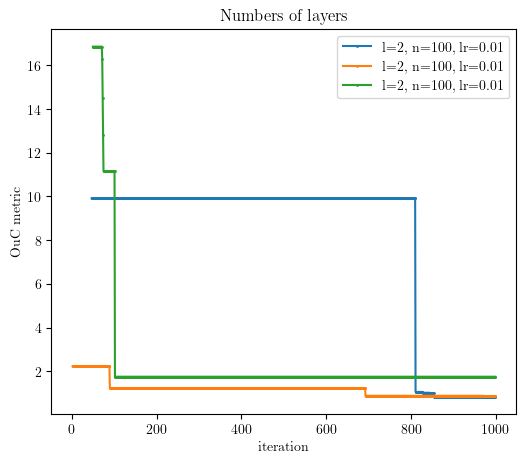

In [31]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8596754 MSE solution: 0.001436697570268976 ratio: 0.124 time: 56.85802745819092
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84687924 MSE solution: 0.0006766445385477 ratio: 0.123 time: 57.10780358314514
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8365137 MSE solution: 0.0015341689961600527 ratio: 0.162 time: 55.88076686859131


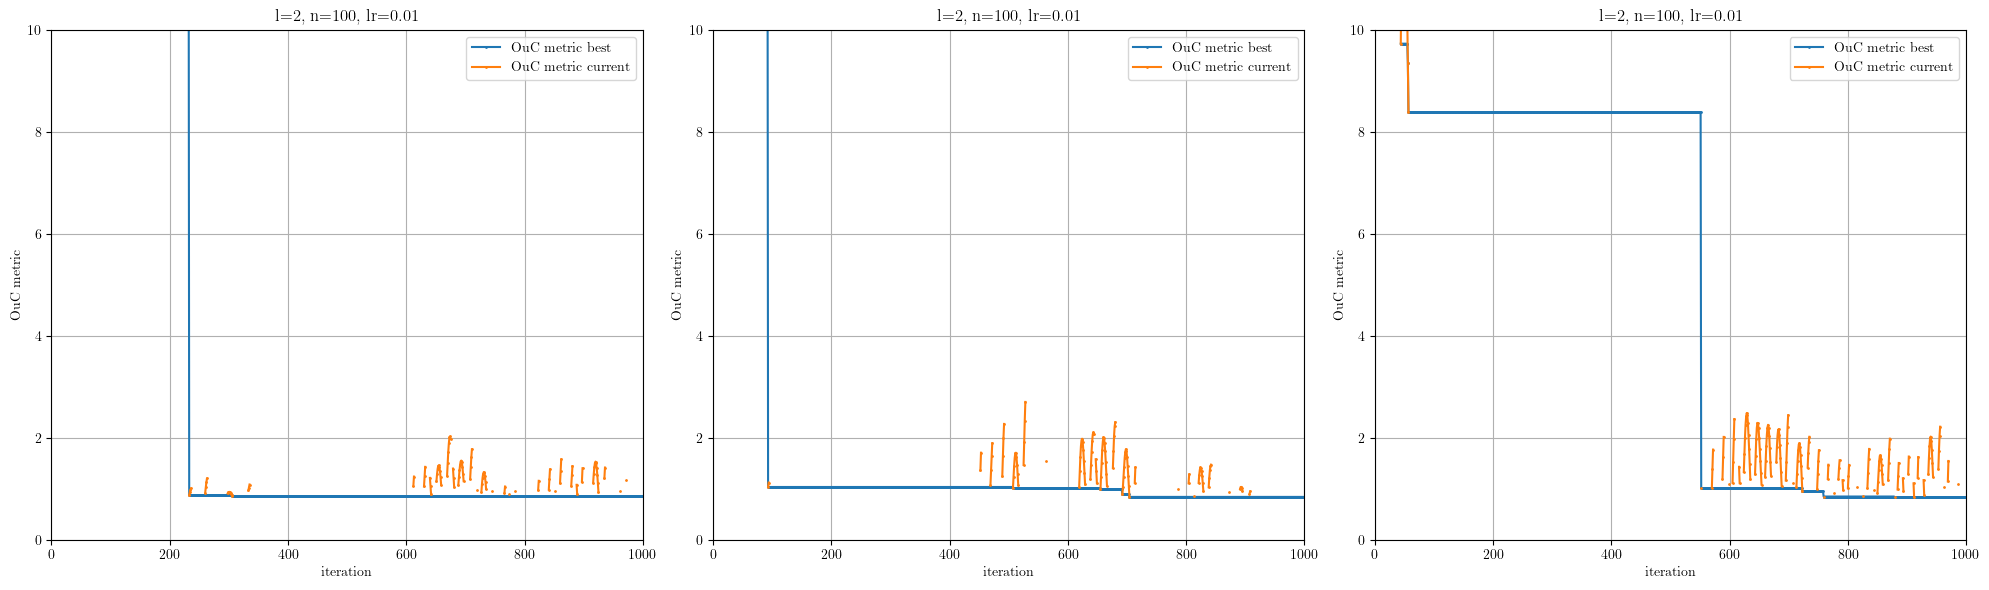

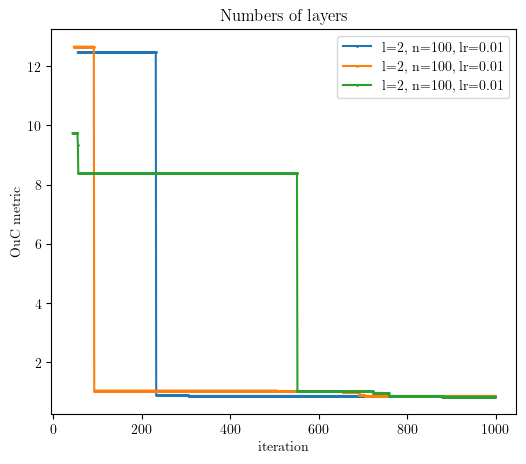

In [32]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.96204484 MSE solution: 0.021652260892058864 ratio: 0.027 time: 52.63404679298401
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8943726 MSE solution: 0.0028993153879359104 ratio: 0.053 time: 60.793909788131714
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.943643 MSE solution: 0.005523639038008894 ratio: 0.13 time: 60.9061005115509


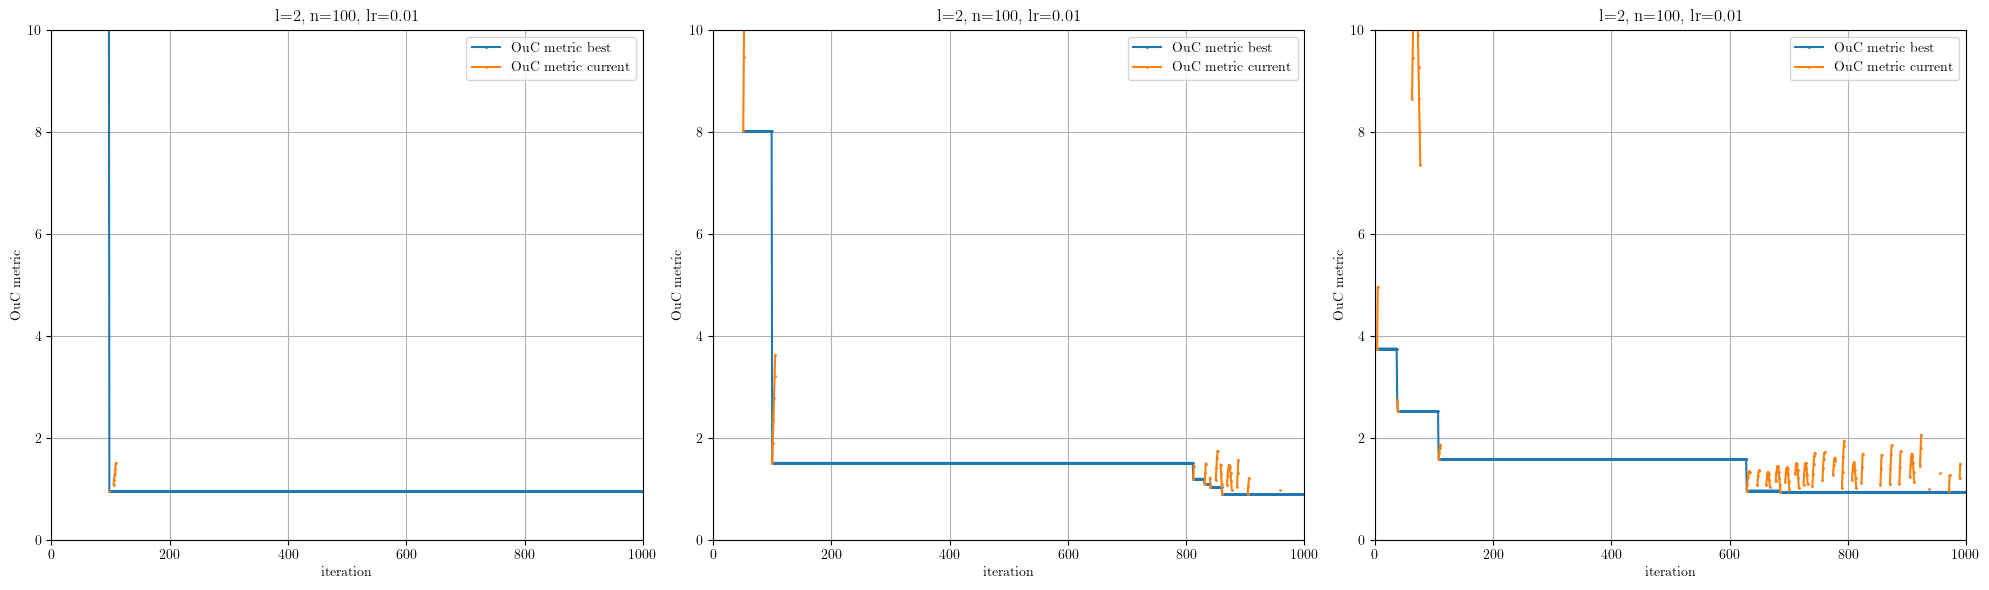

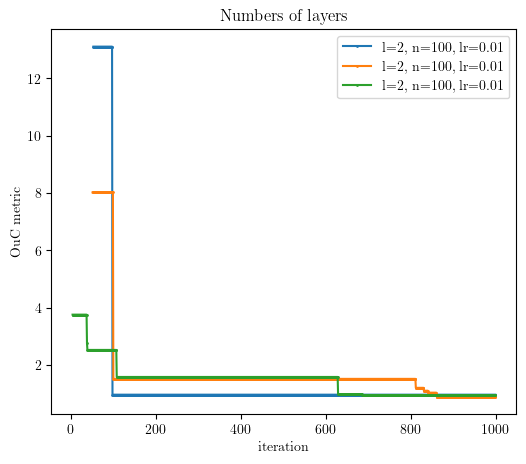

In [33]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8832309 MSE solution: 0.004469251519386203 ratio: 0.13 time: 61.22398328781128
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8819618 MSE solution: 0.004461133250337527 ratio: 0.154 time: 61.81280970573425
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.90982133 MSE solution: 0.008109651012351856 ratio: 0.025 time: 60.003294706344604


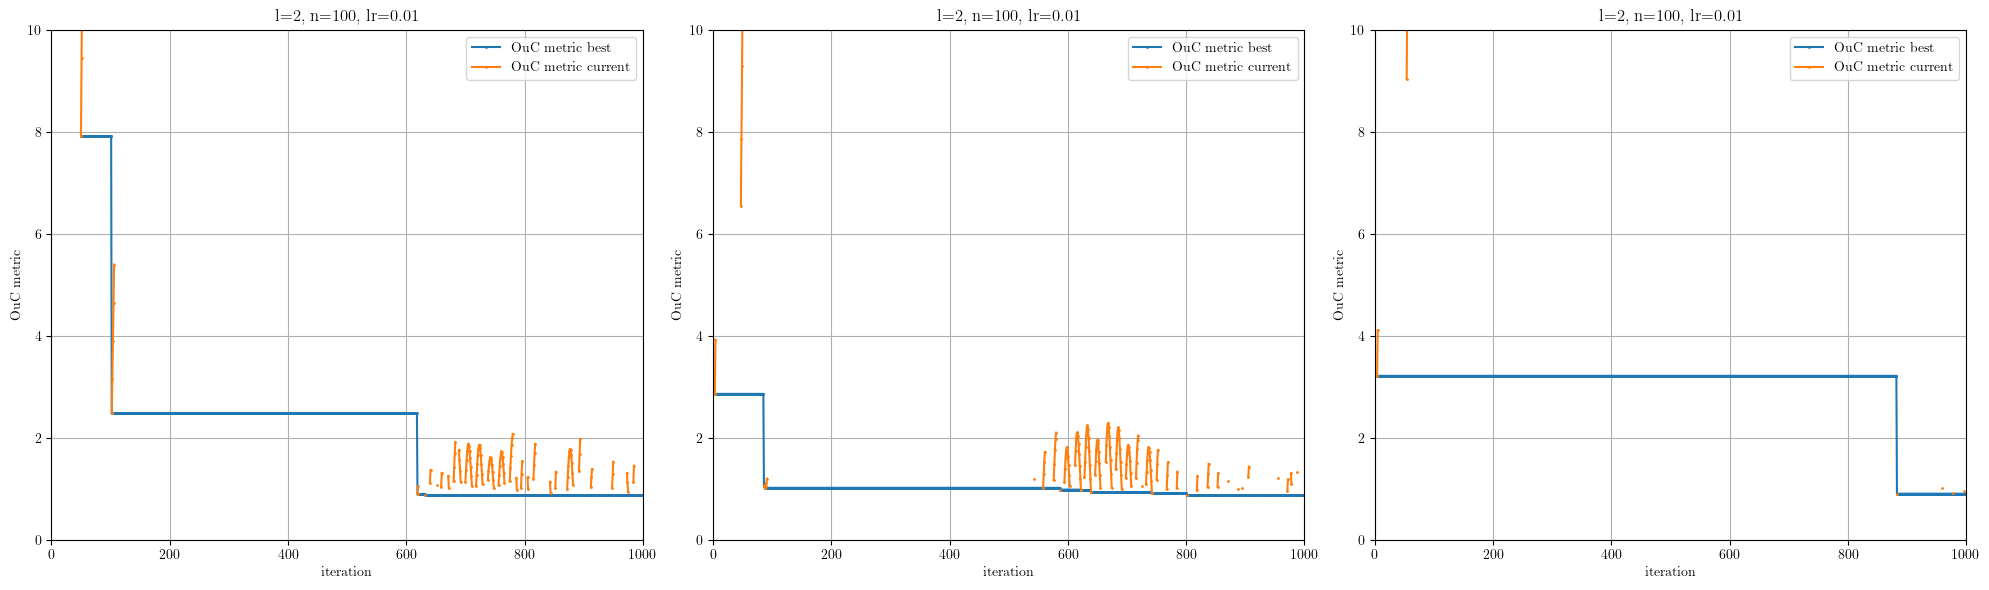

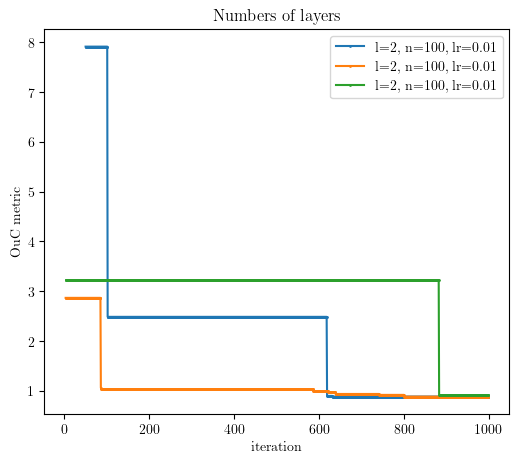

In [34]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8391914 MSE solution: 0.00044112833526946914 ratio: 0.112 time: 62.2306706905365
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8872414 MSE solution: 0.0013617996606518055 ratio: 0.071 time: 62.191654205322266
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9153378 MSE solution: 0.008245085817204116 ratio: 0.018 time: 56.84866714477539


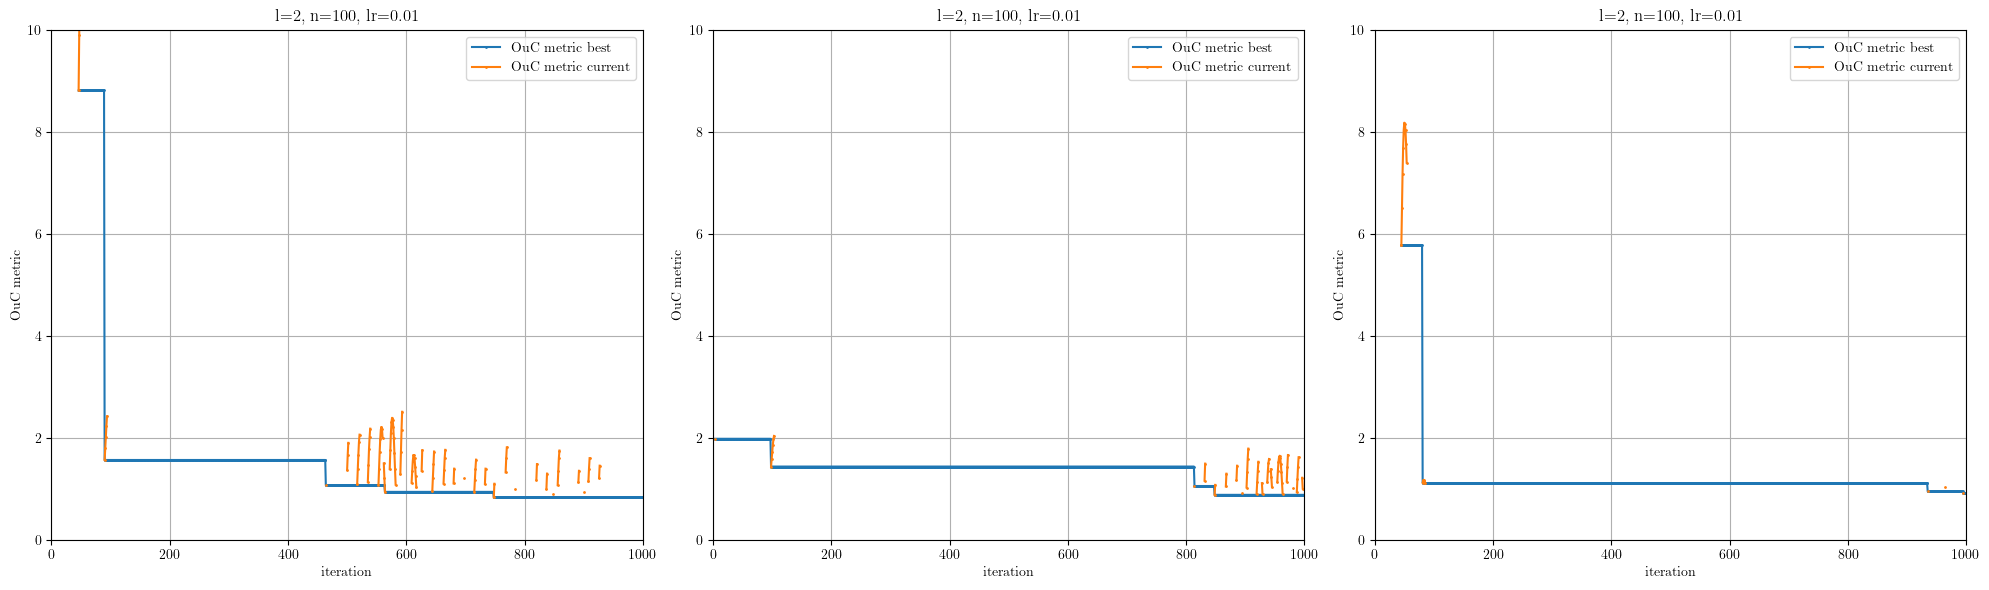

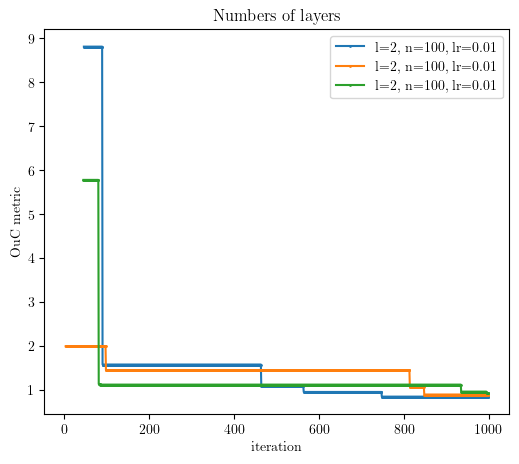

In [35]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8530254 MSE solution: 0.0020903357728991323 ratio: 0.081 time: 55.965776681900024
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8717766 MSE solution: 0.002679122992320537 ratio: 0.031 time: 64.4676628112793
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8644036 MSE solution: 0.0021076864009992704 ratio: 0.142 time: 60.450870513916016


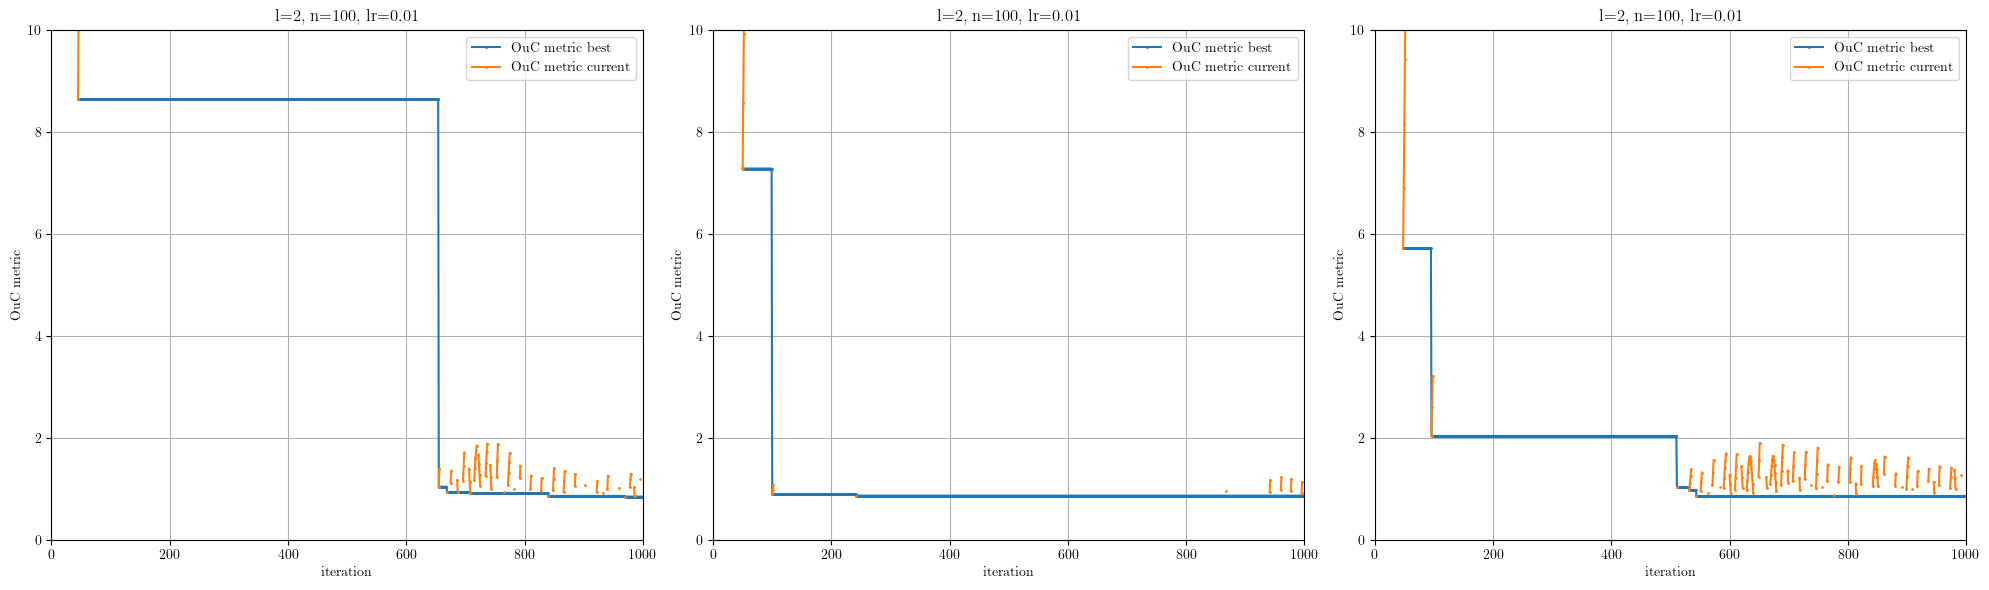

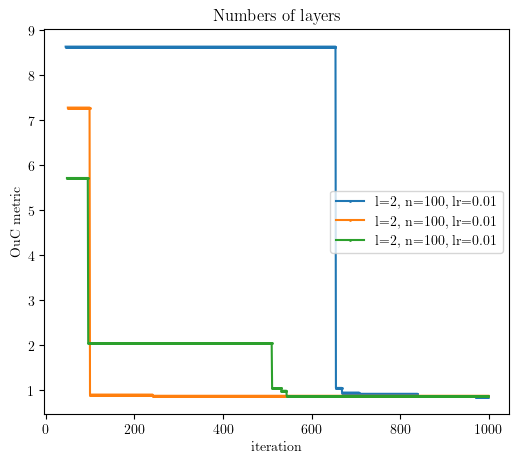

In [36]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8582295 MSE solution: 0.0012549200496291297 ratio: 0.048 time: 66.53652596473694
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8647178 MSE solution: 0.002438007195177424 ratio: 0.02 time: 60.190253257751465
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9529159 MSE solution: 0.00804780648488331 ratio: 0.08 time: 58.81258773803711


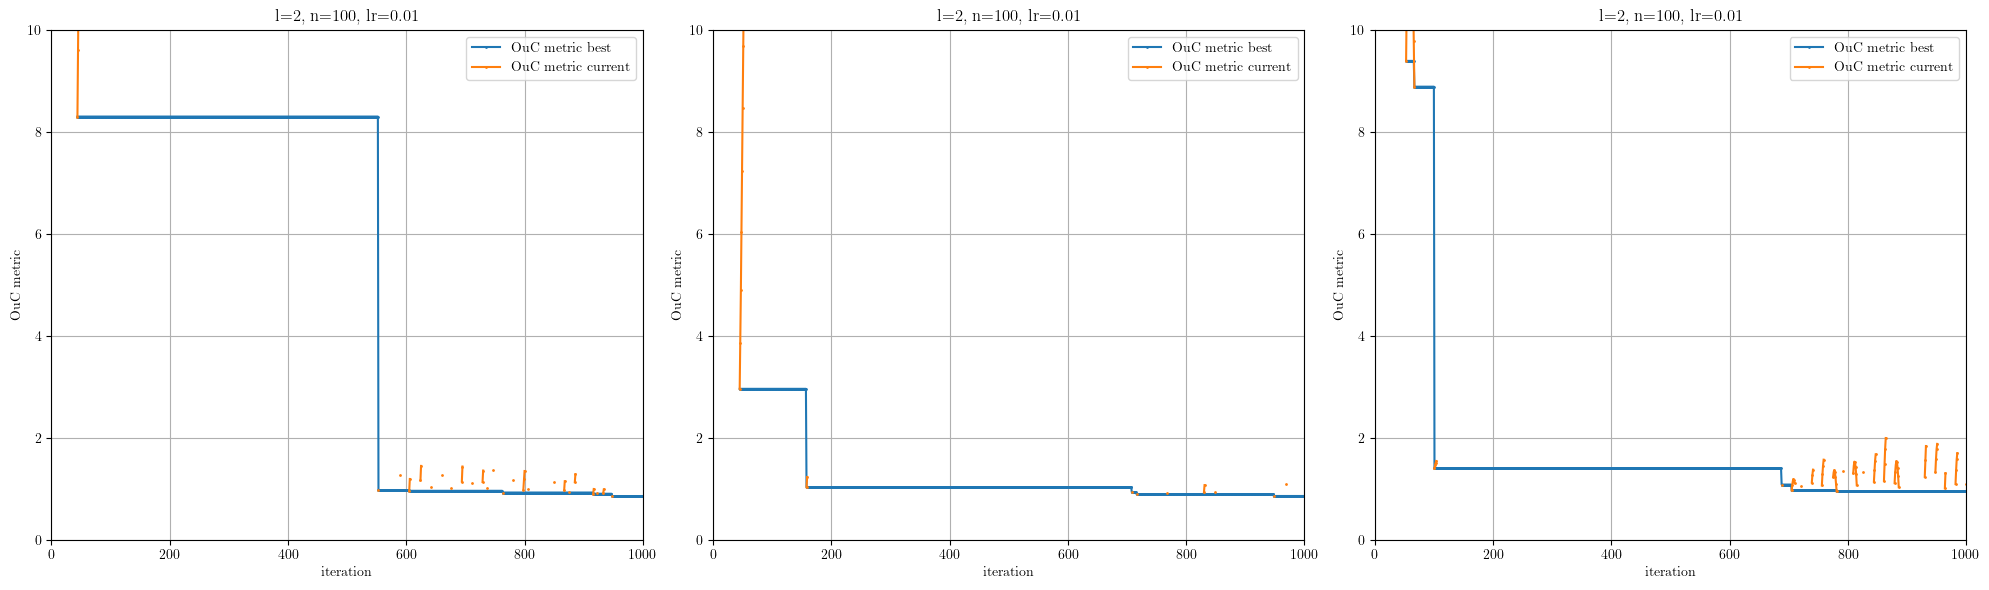

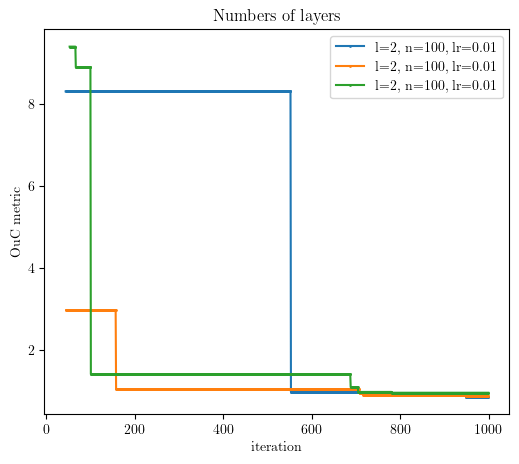

In [37]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8574541 MSE solution: 0.0006599931223934887 ratio: 0.173 time: 59.00498938560486
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88649416 MSE solution: 0.0015356740225660002 ratio: 0.076 time: 54.00794720649719
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86554384 MSE solution: 0.0009140618593903228 ratio: 0.025 time: 52.85990238189697


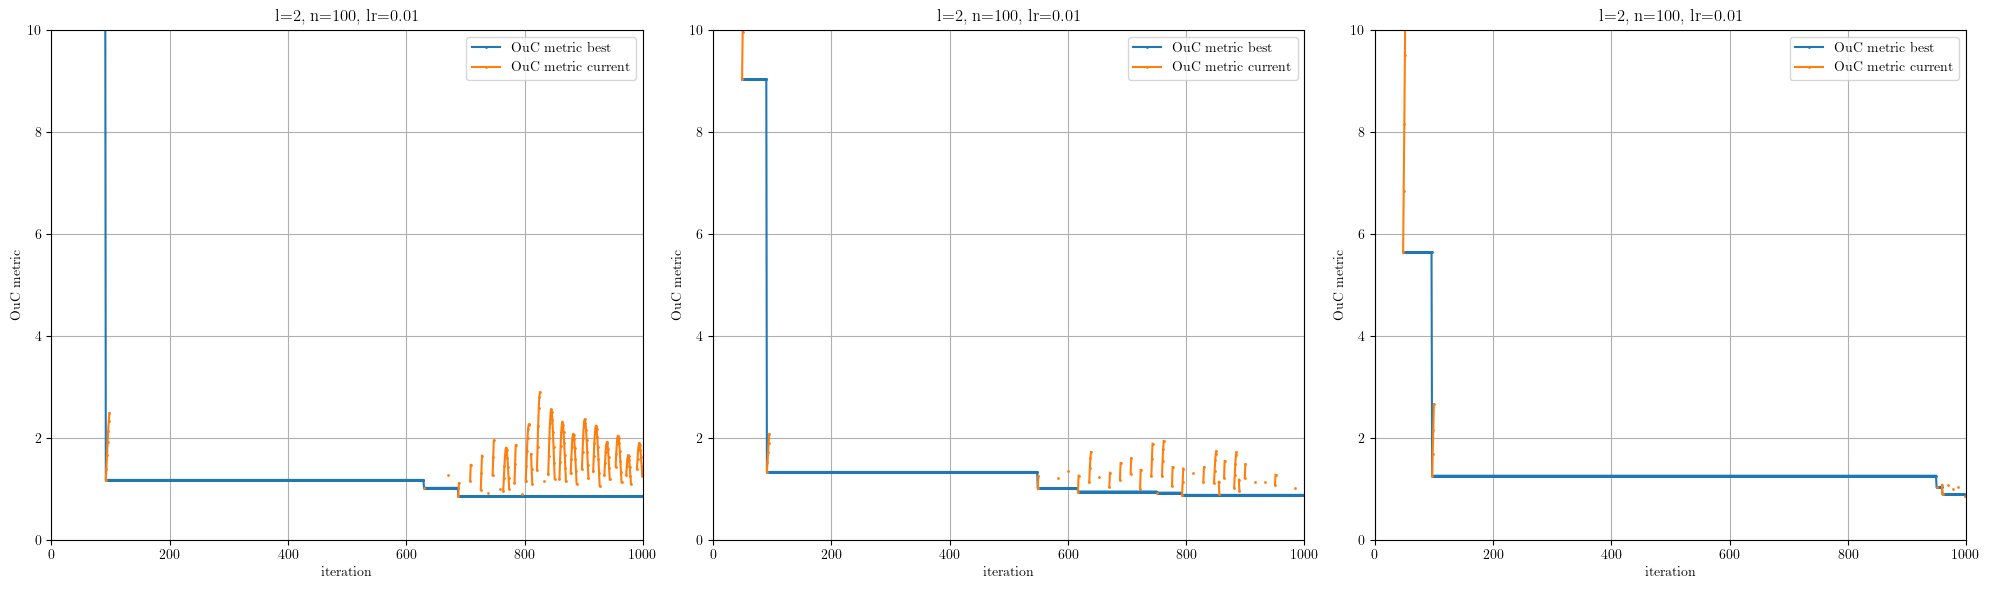

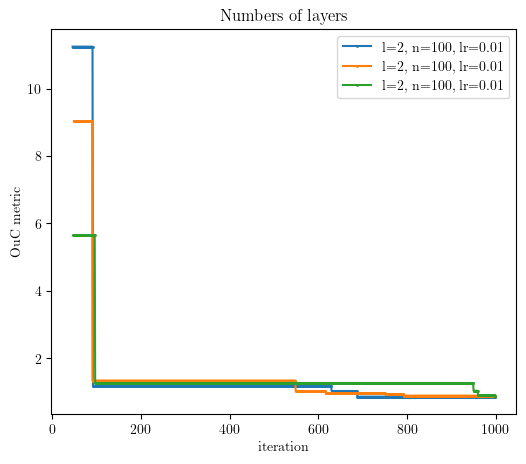

In [38]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8684485 MSE solution: 0.001884235954634597 ratio: 0.116 time: 57.90551543235779
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83760726 MSE solution: 0.0002675327456828098 ratio: 0.084 time: 54.22514295578003
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88910514 MSE solution: 0.006632423949567441 ratio: 0.02 time: 55.47776985168457


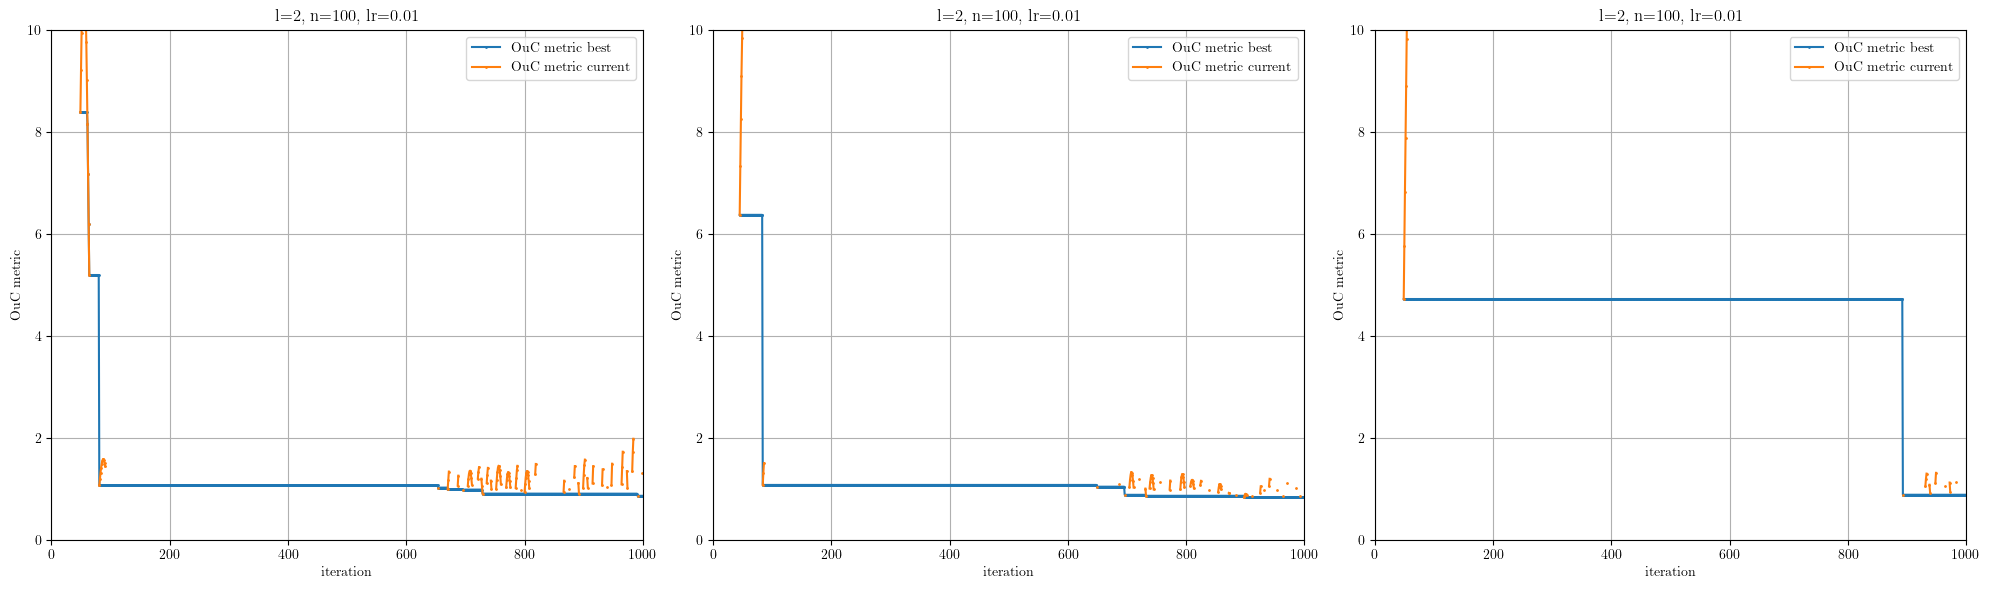

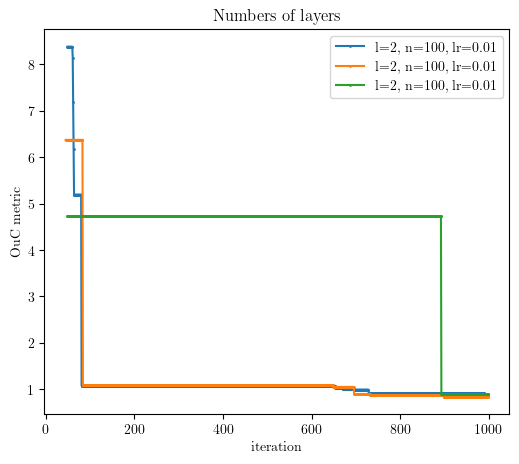

In [39]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.81978816 MSE solution: 5.412983125101522e-05 ratio: 0.106 time: 57.24913048744202
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8384351 MSE solution: 0.0006086393198986079 ratio: 0.147 time: 57.312504529953
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8387888 MSE solution: 0.0004055745205971276 ratio: 0.092 time: 57.36033797264099


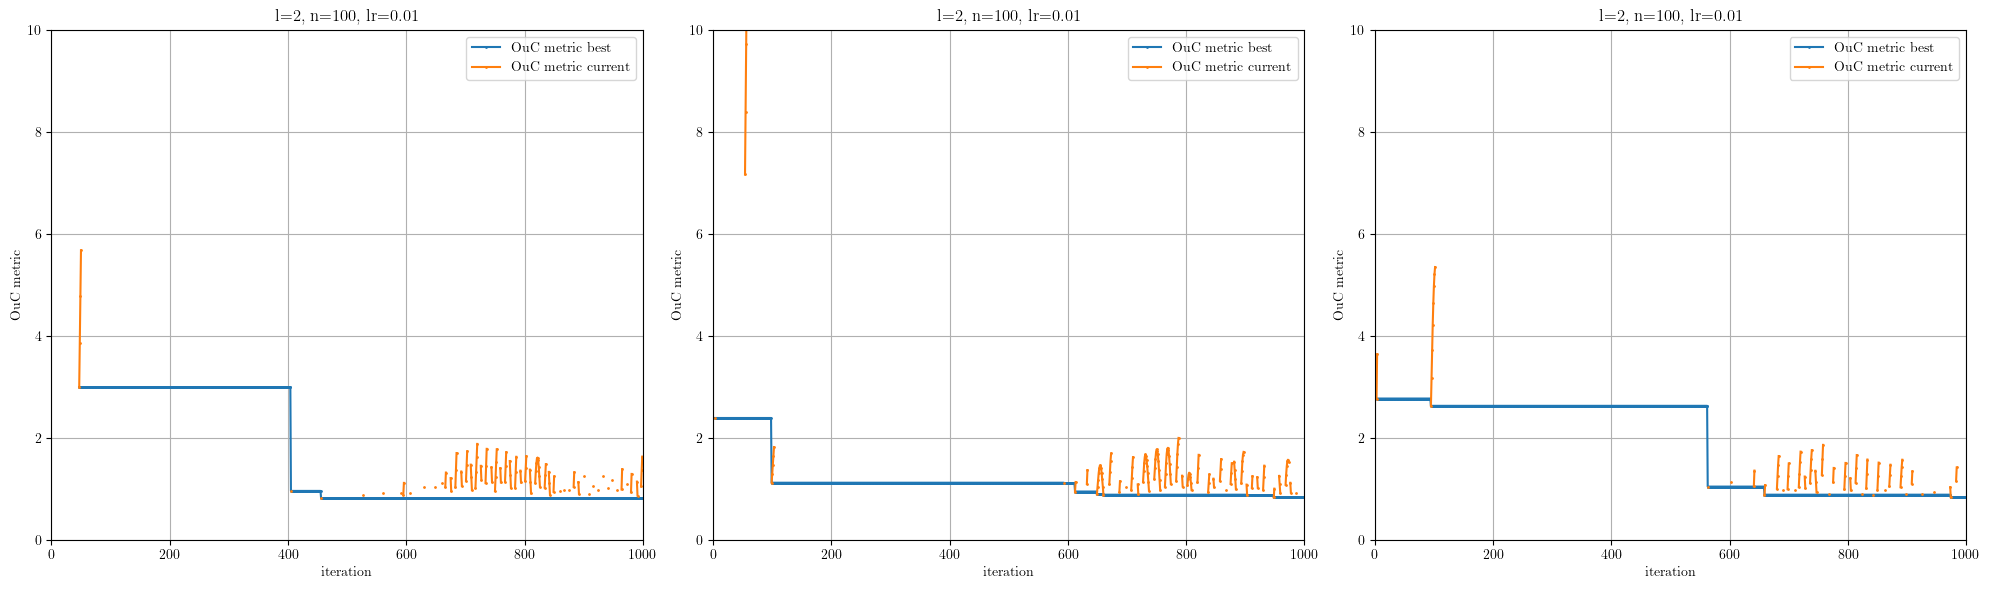

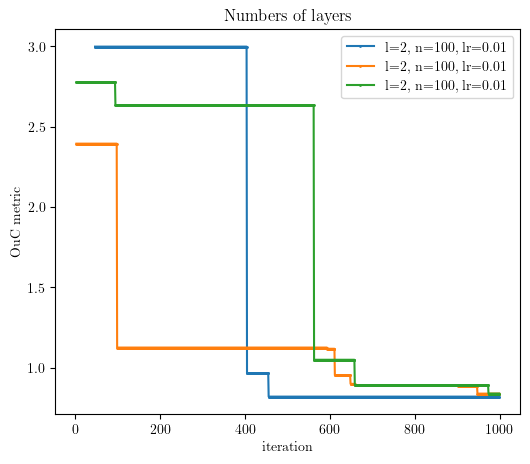

In [40]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8554758 MSE solution: 0.0005176355579613712 ratio: 0.145 time: 56.65502166748047
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8578279 MSE solution: 0.0011006079915204358 ratio: 0.078 time: 56.771437644958496
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.83579147 MSE solution: 0.00023194662420776912 ratio: 0.175 time: 56.73026251792908


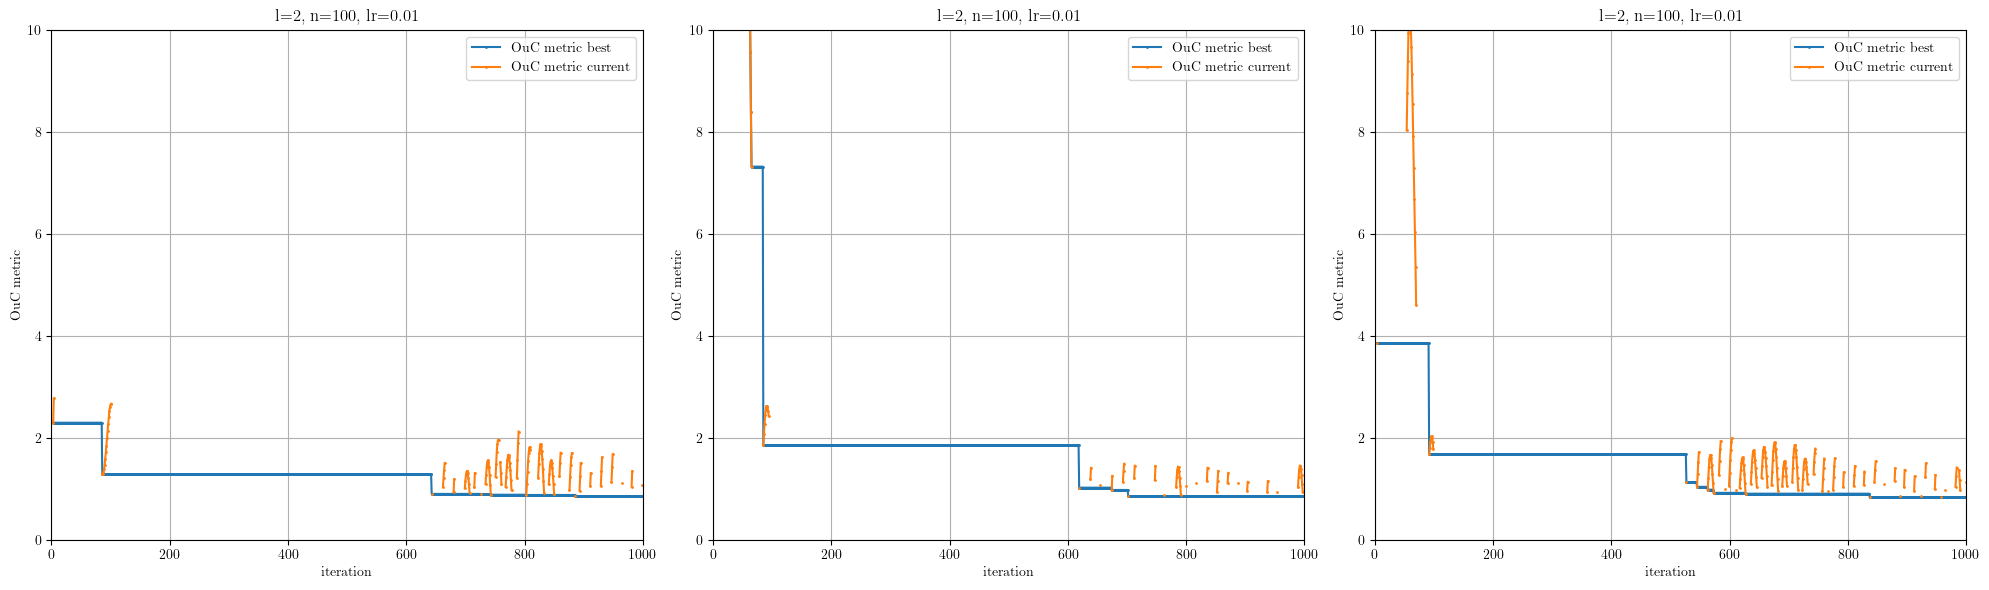

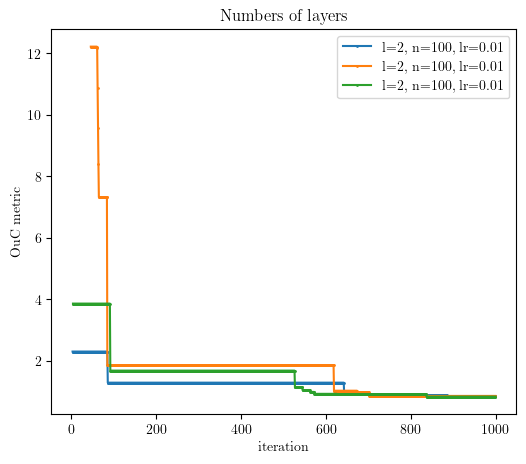

In [41]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84141165 MSE solution: 0.00041163976281984385 ratio: 0.092 time: 56.2538001537323
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.87275326 MSE solution: 0.0010078044808418684 ratio: 0.045 time: 57.860355854034424
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82468855 MSE solution: 0.0002942482703514296 ratio: 0.043 time: 60.43715715408325


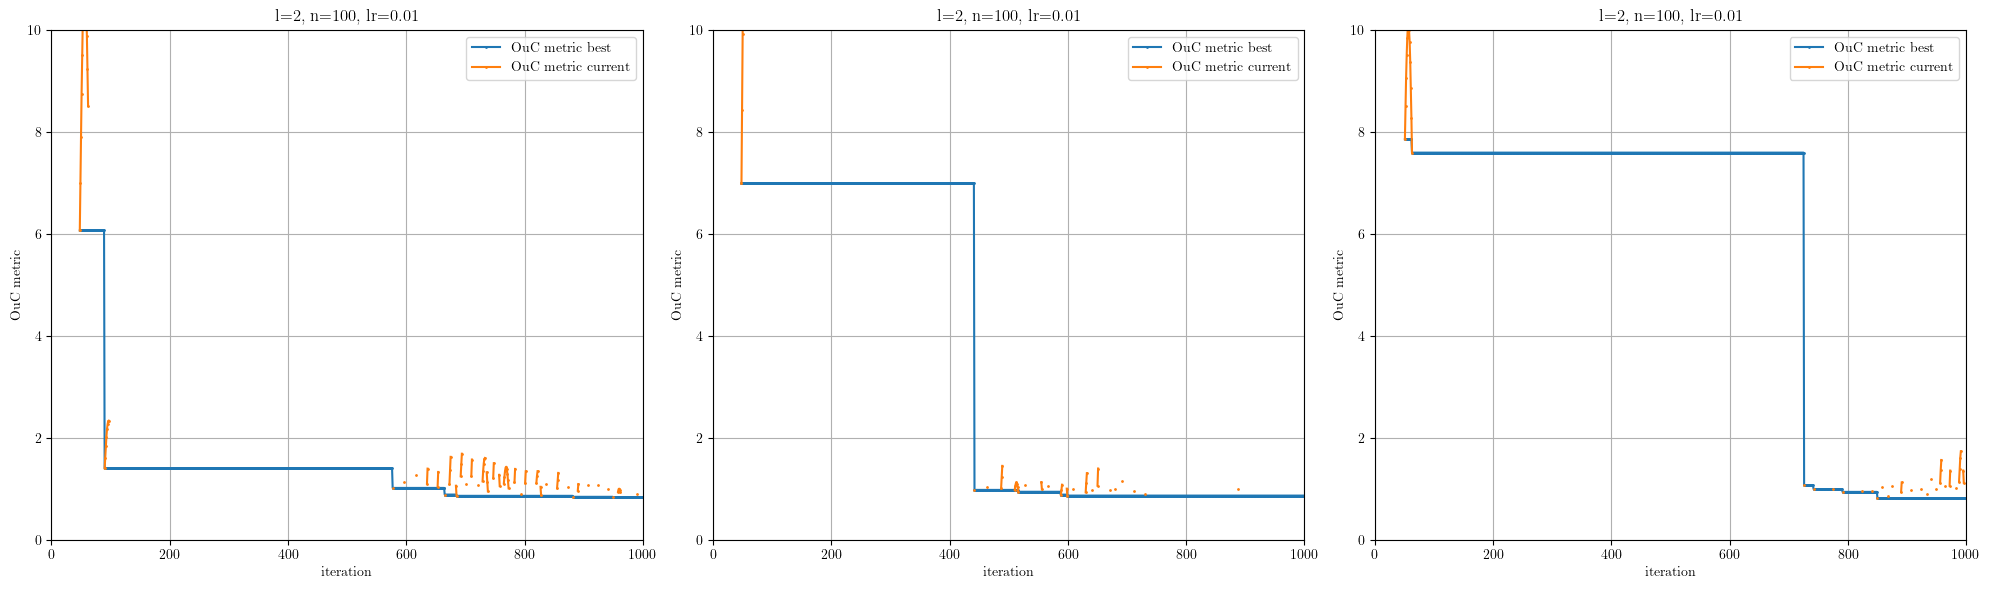

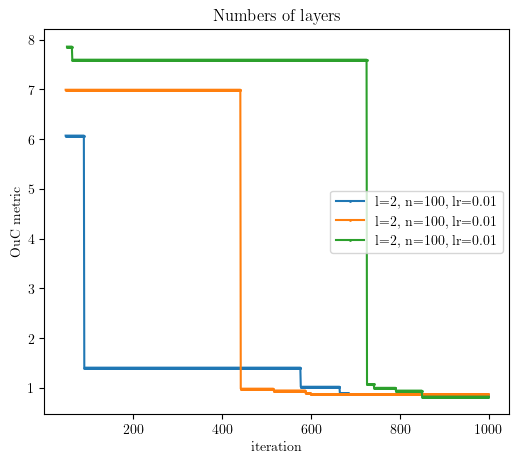

In [42]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.82210445 MSE solution: 0.00010366231905584725 ratio: 0.302 time: 56.92961359024048
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84504735 MSE solution: 0.0013589631693510659 ratio: 0.059 time: 58.222742557525635
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8213319 MSE solution: 0.00010130200370841621 ratio: 0.246 time: 59.95040249824524


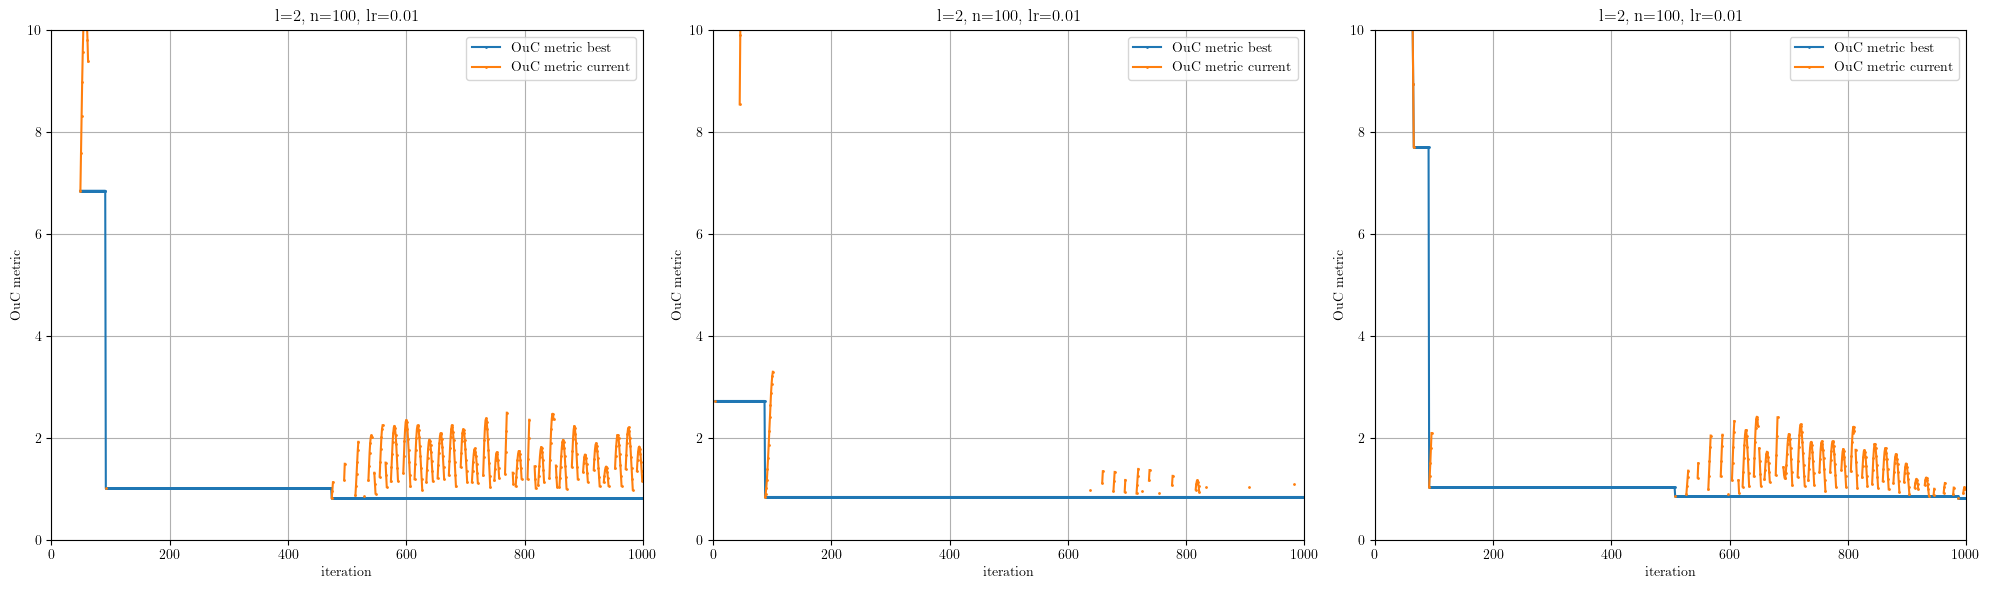

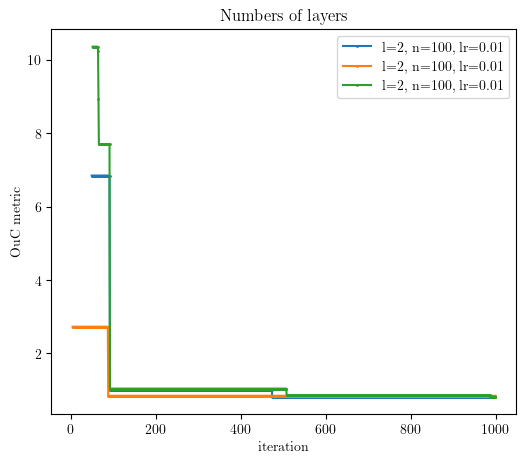

In [43]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 1.0399289 MSE solution: 0.015403433767921774 ratio: 0.021 time: 57.36859846115112
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.95336884 MSE solution: 0.016654259565711035 ratio: 0.03 time: 58.103777170181274
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8520114 MSE solution: 0.0017091746107841842 ratio: 0.115 time: 57.16666579246521


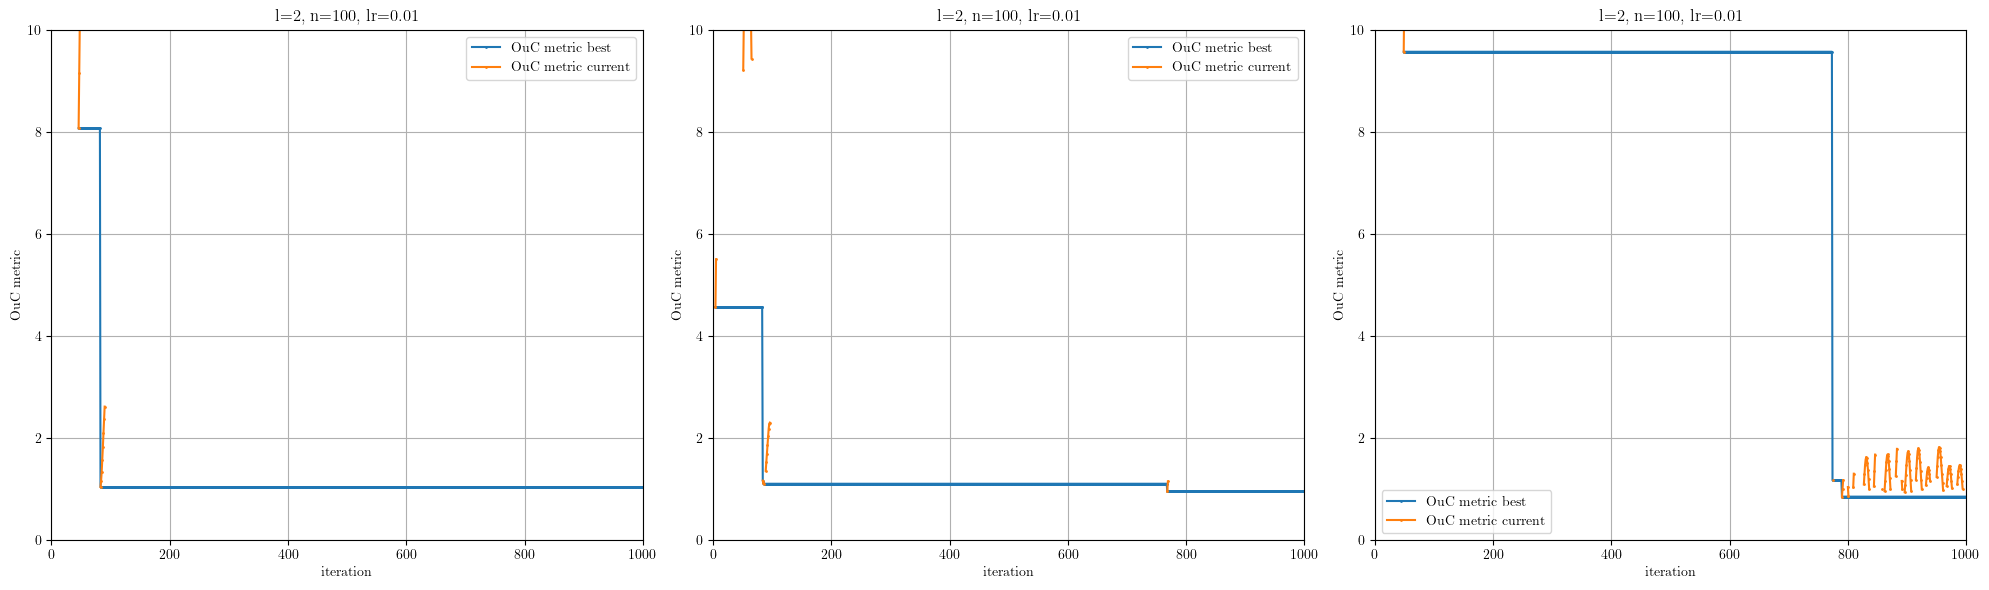

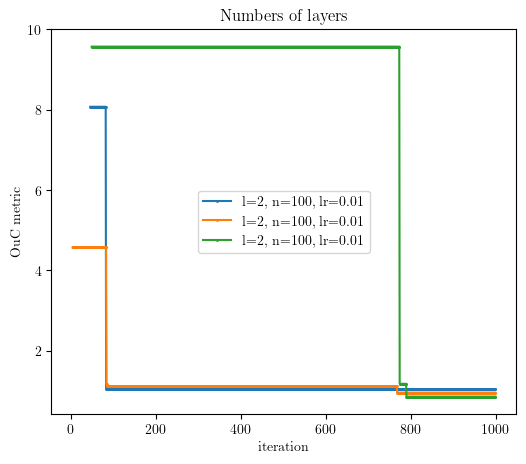

In [44]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8809213 MSE solution: 0.0028907092635961085 ratio: 0.04 time: 58.69525861740112
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8752297 MSE solution: 0.001185519523396928 ratio: 0.19 time: 57.026174783706665
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.85135794 MSE solution: 0.0008686626892488695 ratio: 0.204 time: 58.66177439689636


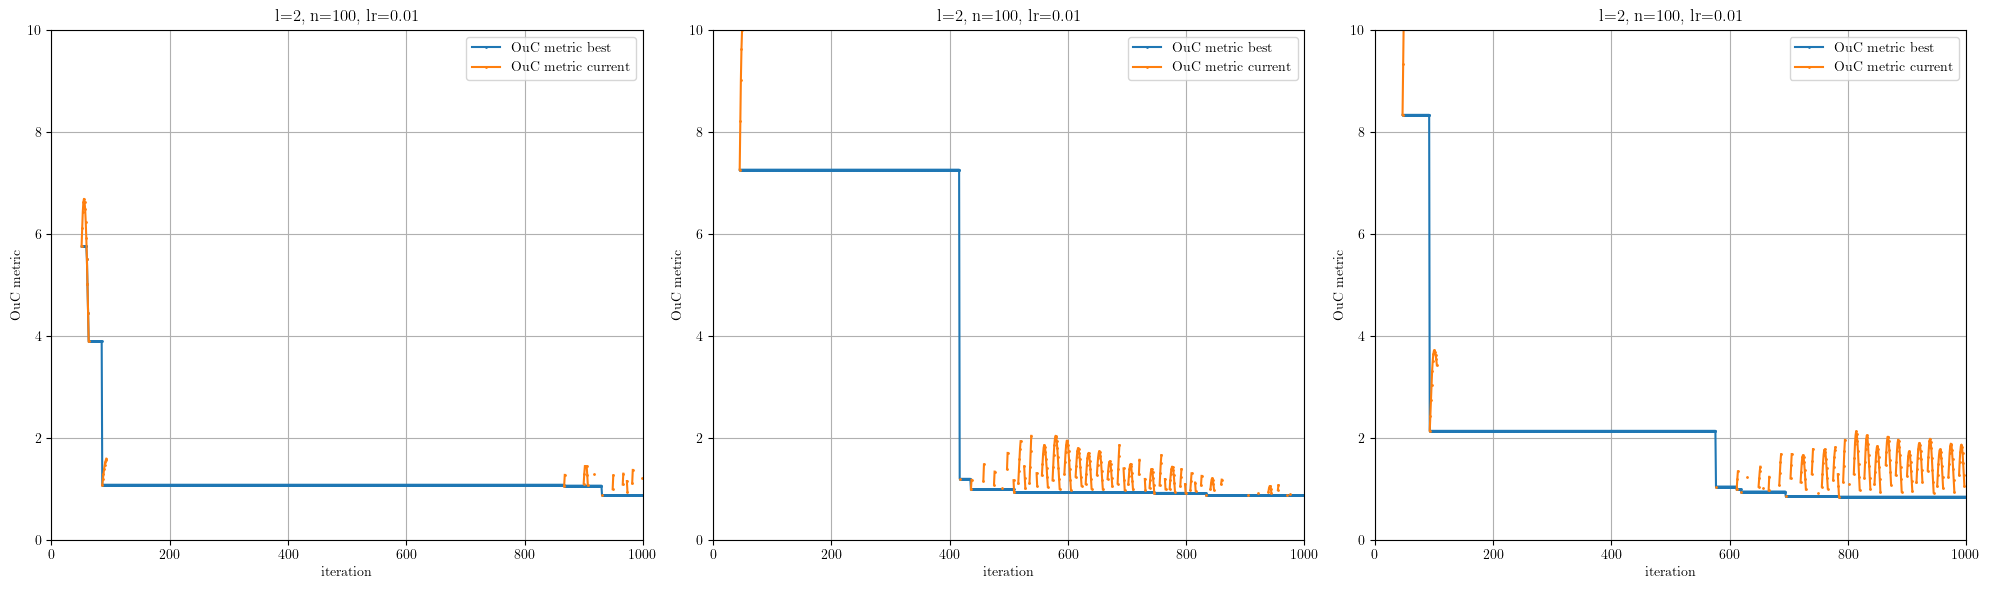

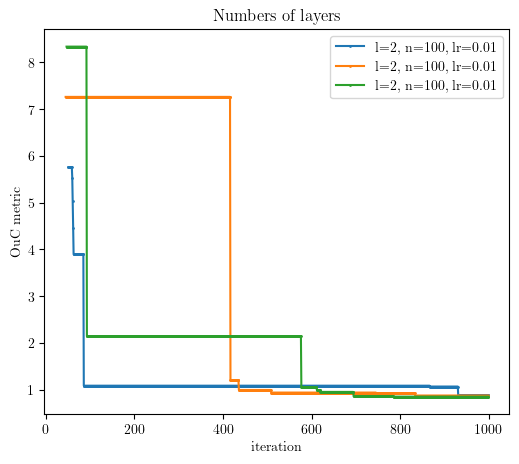

In [45]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86142266 MSE solution: 0.0029560007503414924 ratio: 0.03 time: 56.54802322387695
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 2.0886798 MSE solution: 0.2636977776483062 ratio: 0.016 time: 55.84580850601196
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8695986 MSE solution: 0.0049381813139874565 ratio: 0.093 time: 56.78912854194641


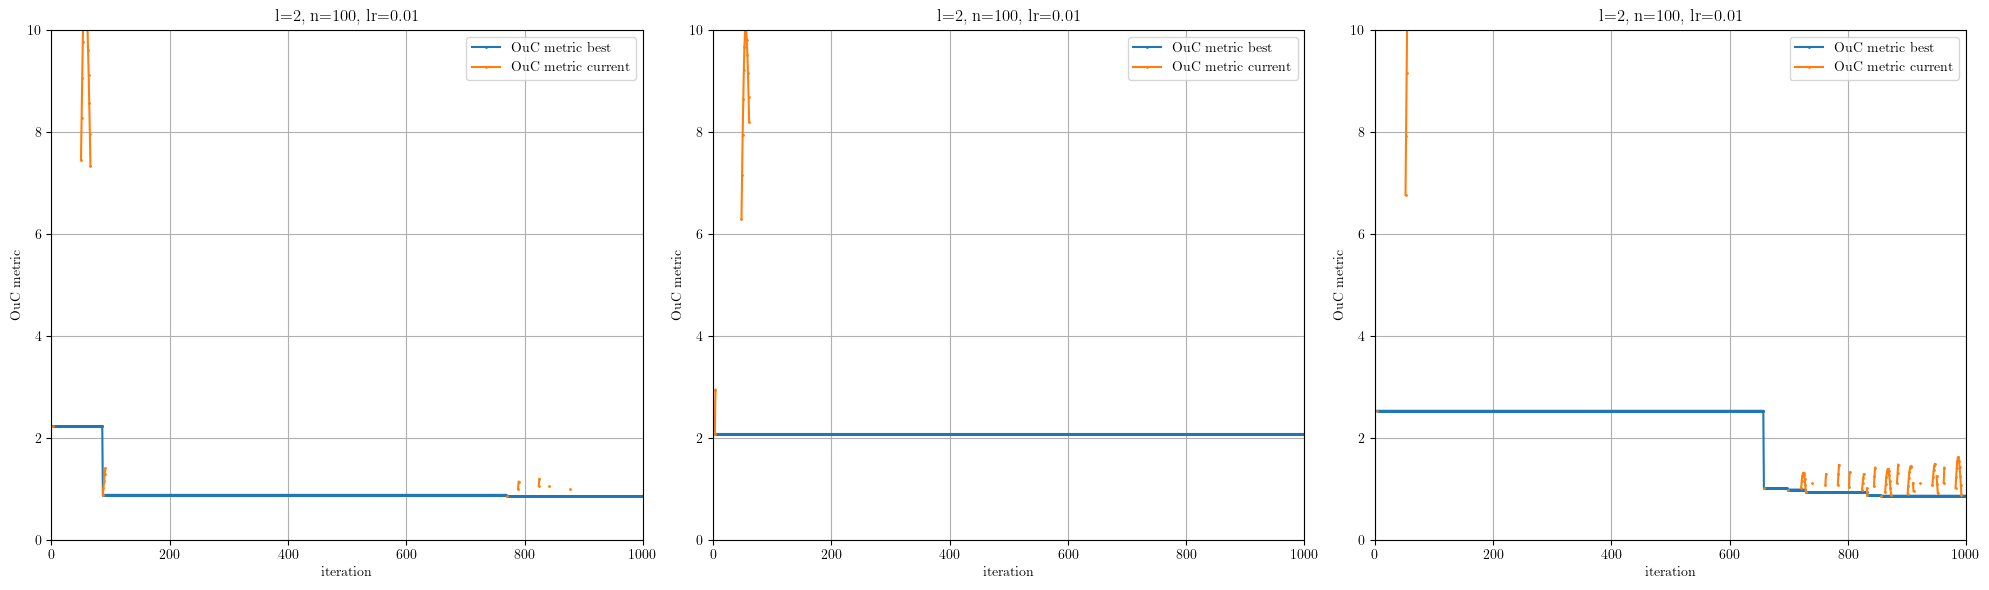

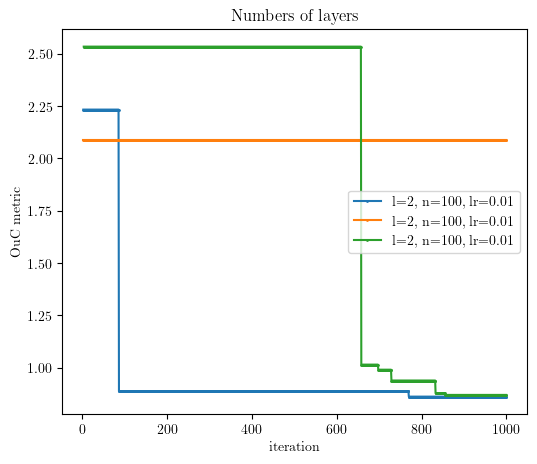

In [46]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.9092117 MSE solution: 0.00300014776831325 ratio: 0.072 time: 60.76963400840759
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.86124116 MSE solution: 0.002103195360444169 ratio: 0.066 time: 57.52008414268494
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.8684433 MSE solution: 0.0010348481278316557 ratio: 0.2 time: 61.42083954811096


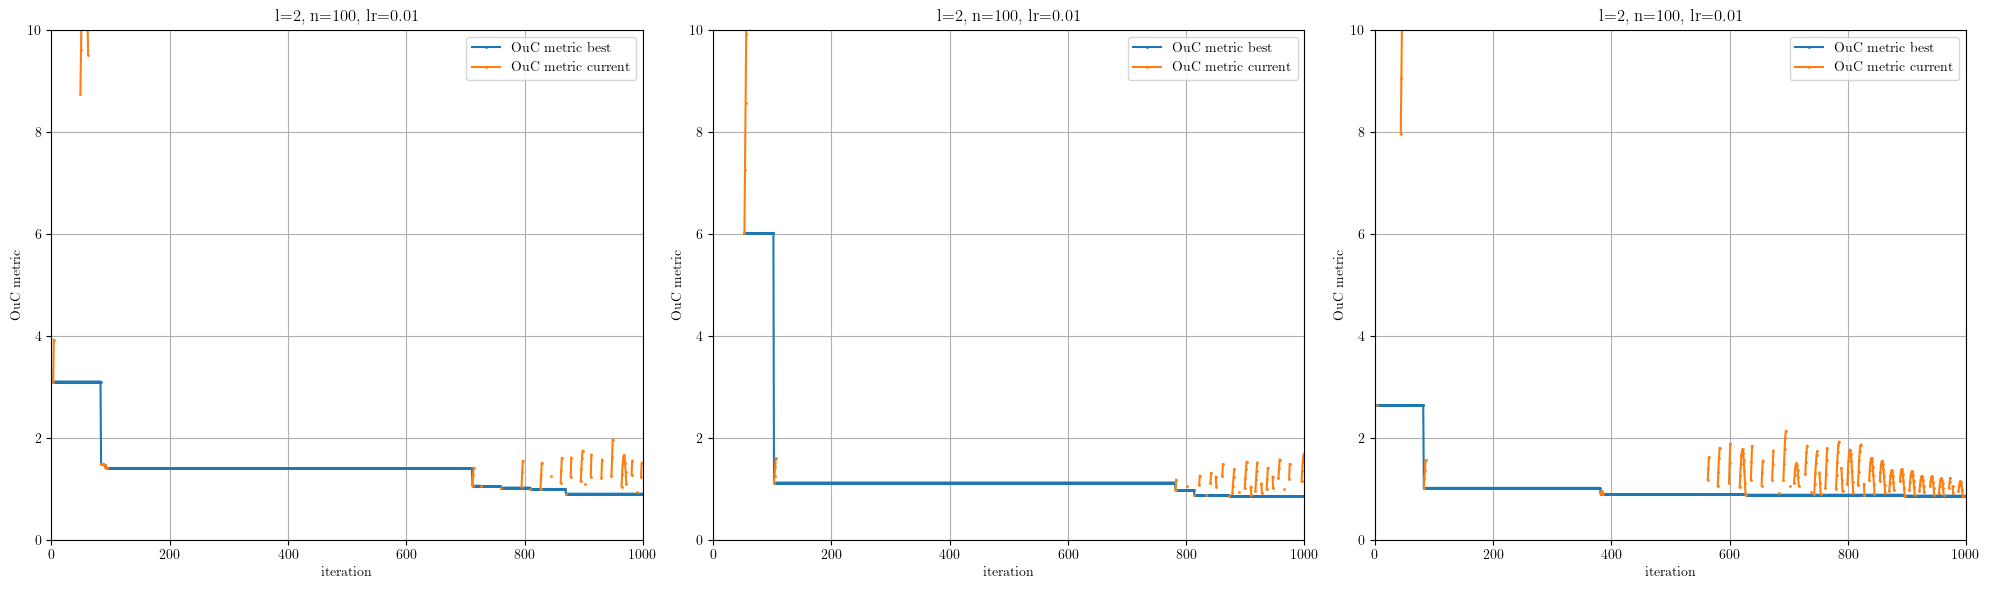

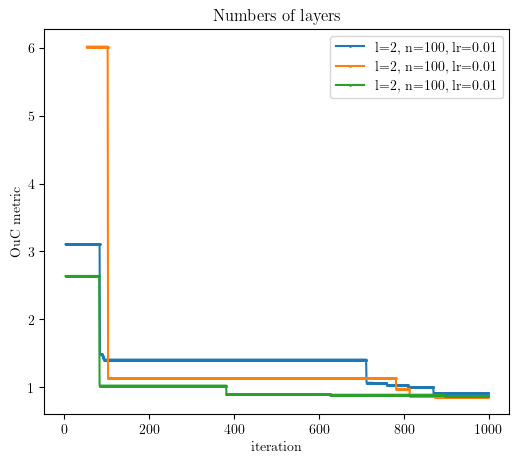

In [47]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_21974/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_21974/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.84128577 MSE solution: 0.0003259487472879247 ratio: 0.055 time: 57.798765659332275
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.88600814 MSE solution: 0.004664971257556743 ratio: 0.056 time: 64.3050045967102
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 0.92619383 MSE solution: 0.00393172655133997 ratio: 0.026 time: 59.638081550598145


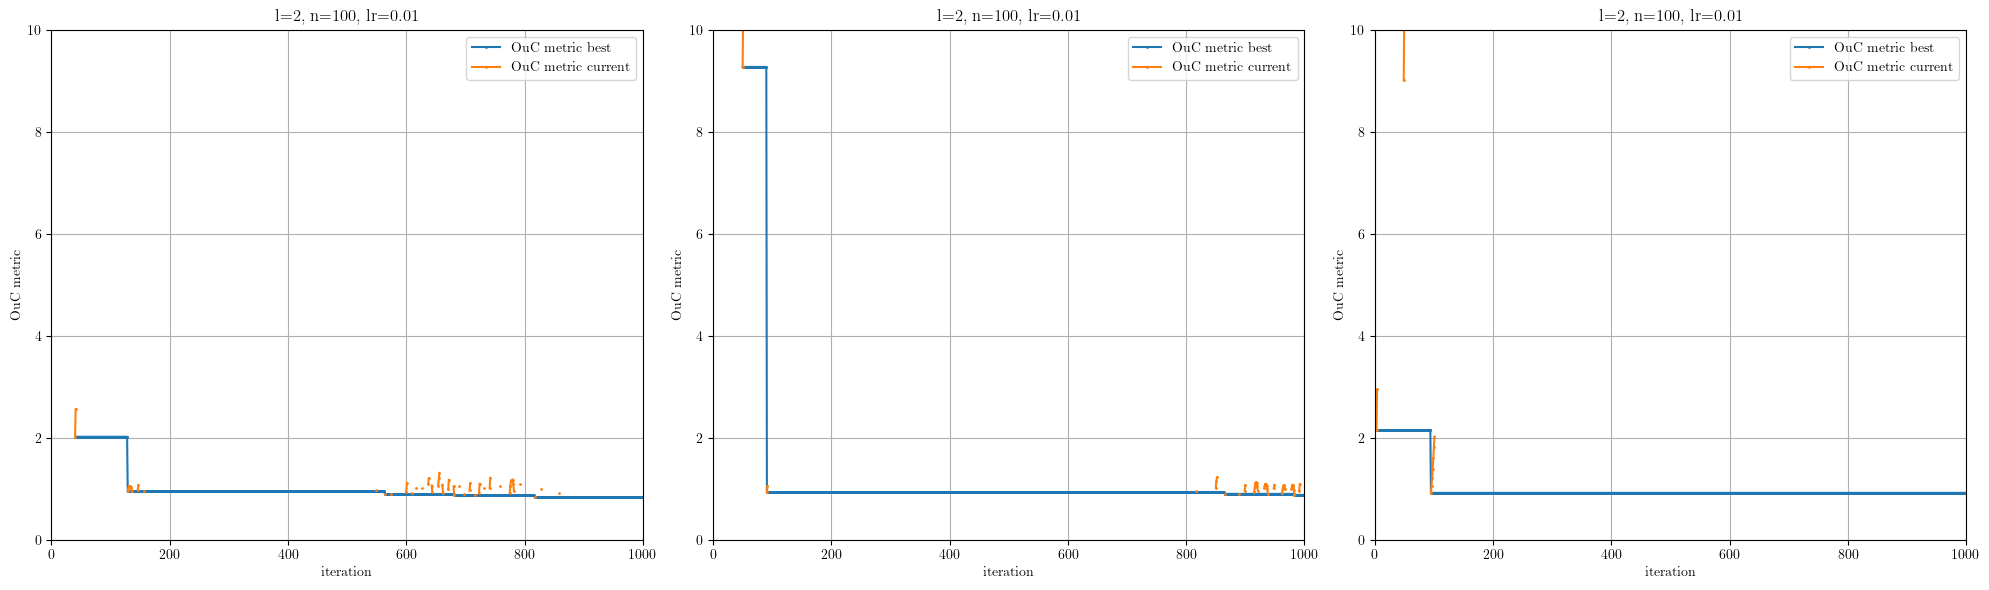

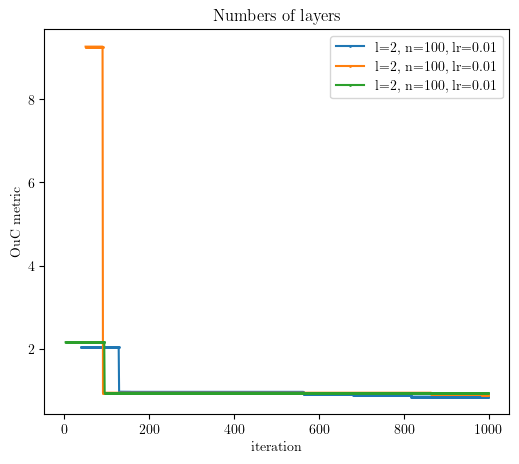

In [48]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [49]:
import plotly.express as px
import pandas as pd

# Convert the list of hyperparameter combinations into a DataFrame
df = pd.DataFrame(hyperparameter_combinations)

# Create an interactive scatter plot with ratio_mean on x-axis and error_mean on y-axis
fig = px.scatter(df, 
                 x='error_mean', 
                 y='ratio_mean', 
                 hover_data=['WEIGHTING', 'CONSTRAINT_WEIGHT'],
                 labels={
                     'ratio_mean': 'Ratio Mean',
                     'error_mean': 'Error Mean'
                 },
                 title='Hyperparameter Tuning: Ratio Mean vs. Error Mean')

# Show the interactive plot
fig.show()